# Conway's Game of Life

Numpy is slanted toward scientific computing and we'll consider in this section the _Game of Life_ by _John Conway_ which is one of the earliest example of cellular automata (see figure below). Those cellular automaton can be conveniently considered as array of cells that are connected together through the notion of neighbours. We'll show in the following sections implementation of this game using pure python and numpy in order to illustrate main differences with python and numpy.
![Game of Life](http://www.labri.fr/perso/nrougier/teaching/numpy/figures/game-of-life.png)

The Game of Life, also known simply as Life, is a cellular automaton devised by the British mathematician _John Horton Conway_ in 1970. It is the best-known example of a cellular automaton. The "game" is actually a _zero-player_ game, meaning that its evolution is determined by its initial state, needing no input from human players. One interacts with the Game of Life by creating an initial configuration and observing how it evolves.

The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

1. __Overpopulation__: if a living cell is surrounded by more than three living cells, it dies.
2. __Stasis__: if a living cell is surrounded by two or three living cells, it survives.
3. __Underpopulation__: if a living cell is surrounded by fewer than two living cells, it dies.
4. __Reproduction__: if a dead cell is surrounded by exactly three cells, it becomes a living cell.

The initial pattern constitutes the '_seed_' of the system. The first generation is created by applying the above rules simultaneously to every cell in the seed – births and deaths happen simultaneously, and the discrete moment at which this happens is sometimes called a tick. (In other words, each generation is a pure function of the one before.) The rules continue to be applied repeatedly to create further generations.

## JSAnimation Package
We need _JSAnimation Package_ installed in order to animate results. Plesae follow instructions in __Blackboard__ in order to install it if you haven't done that yet.

## Python Code
Because the _Game of Life_ is so simple, the time step can be computed rather tersely in Python. Here there are two possibilities: one using generator expressions, and one using the convolve2d function from scipy. Note that neither of these are extremely performant: they involve creating several temporary arrays, and will not work well for large problems with many time steps. Nevertheless, the simplicity makes these functions very attractive, and they are absolutely sufficient for the small examples we'll consider here:

In [6]:
import numpy as np

def life_step_1(X):
    """Game of life step using generator expressions"""
    nbrs_count = sum(np.roll(np.roll(X, i, 0), j, 1)
                     for i in (-1, 0, 1) for j in (-1, 0, 1)
                     if (i != 0 or j != 0))
    return (nbrs_count == 3) | (X & (nbrs_count == 2))

def life_step_2(X):
    """Game of life step using scipy tools"""
    from scipy.signal import convolve2d
    nbrs_count = convolve2d(X, np.ones((3, 3)), mode='same', boundary='wrap') - X
    return (nbrs_count == 3) | (X & (nbrs_count == 2))
    
life_step = life_step_1

As you can see at the end of the above code, the default version is _life_step_1(X)_ by using alias _life_step_. You can change it to use the second implementation by replacing the last line by: _life_step = life_step_2_.

Note that we've made a choice here about the game boundary. Classically, the game takes place on an infinite, flat plane. Here, for simplicity, we've used a torroidal geometry (likely familiar to players of 1980s computer games like _Asteroids_), where the grid wraps from top to bottom and left to right.

Now we'll use the matplotlib animation submodule to visualize the results:

In [7]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation

def life_animation(X, dpi=10, frames=10, interval=300, mode='loop'):
    """Produce a Game of Life Animation
    
    Parameters
    ----------
    X : array_like
        a two-dimensional numpy array showing the game board
    dpi : integer
        the number of dots per inch in the resulting animation.
        This controls the size of the game board on the screen
    frames : integer
        The number of frames to compute for the animation
    interval : float
        The time interval (in milliseconds) between frames
    mode : string
        The default mode of the animation.  Options are ['loop'|'once'|'reflect']
    """
    X = np.asarray(X)
    assert X.ndim == 2
    X = X.astype(bool)
    
    X_blank = np.zeros_like(X)
    figsize = (X.shape[1] * 1. / dpi, X.shape[0] * 1. / dpi)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)
    im = ax.imshow(X, cmap=plt.cm.binary, interpolation='nearest')
    im.set_clim(-0.05, 1)  # Make background gray

    # initialization function: plot the background of each frame
    def init():
        im.set_data(X_blank)
        return (im,)

    # animation function.  This is called sequentially
    def animate(i):
        im.set_data(animate.X)
        animate.X = life_step(animate.X)
        return (im,)
    animate.X = X

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=interval)
    
    #print anim_to_html(anim)
    return display_animation(anim, default_mode=mode)

## Experimenting with a random starting field
Let's give this a try with a random starting field:


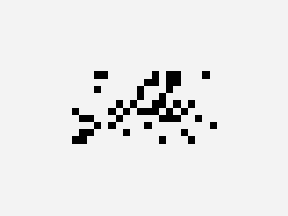
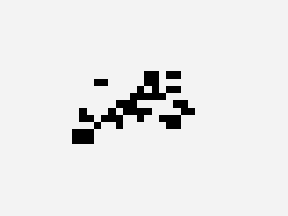
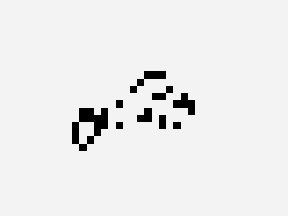
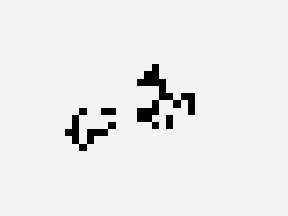
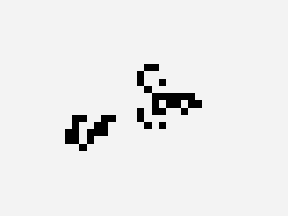
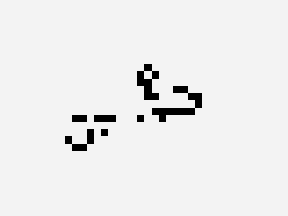
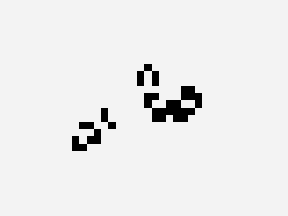
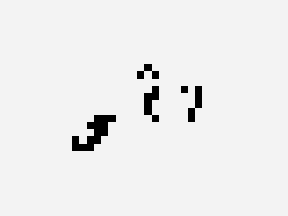
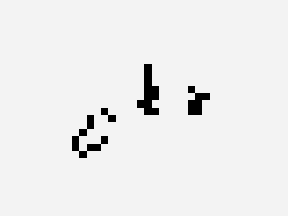
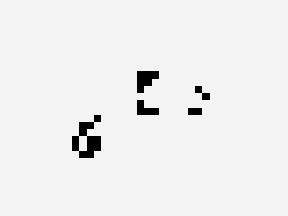
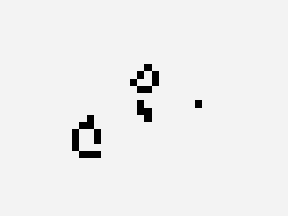
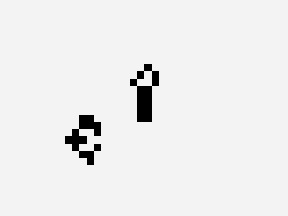
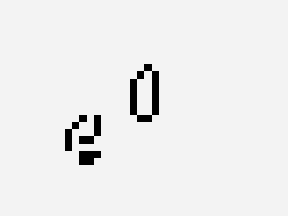
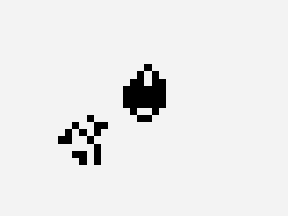
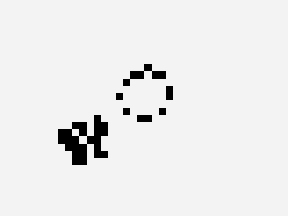
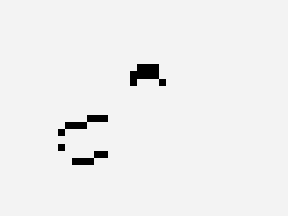
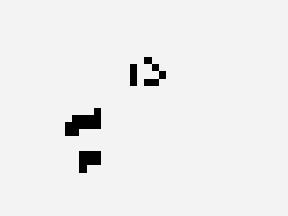
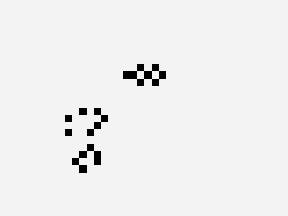
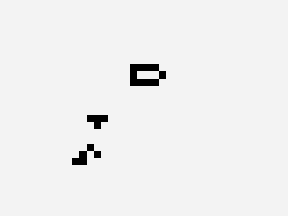
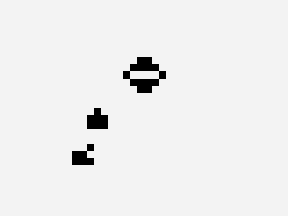
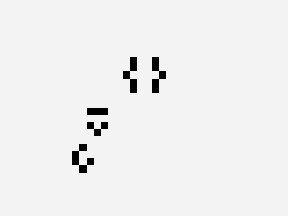
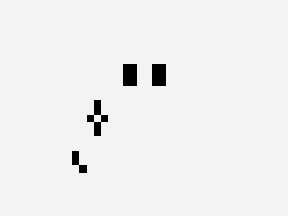
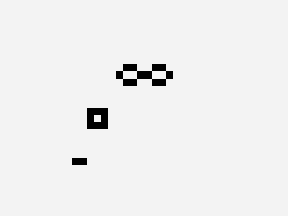
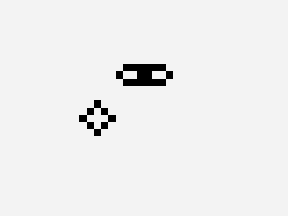
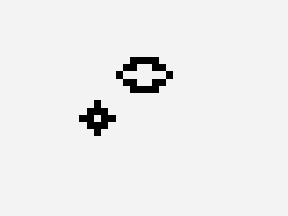
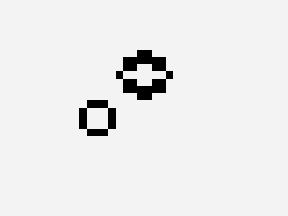
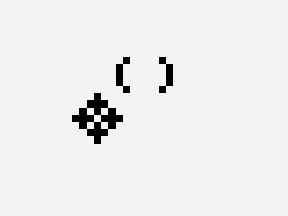
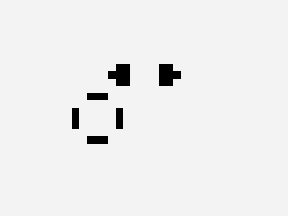
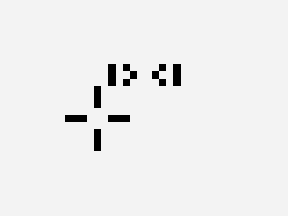
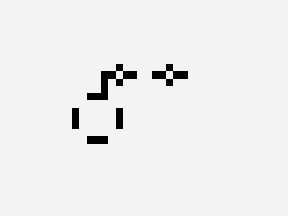
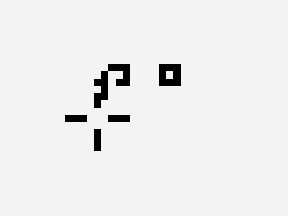
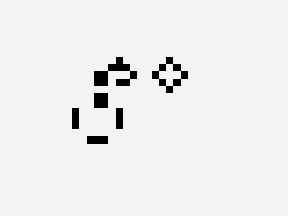
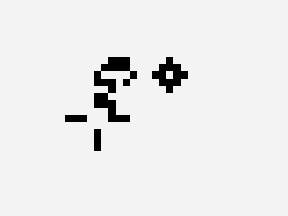
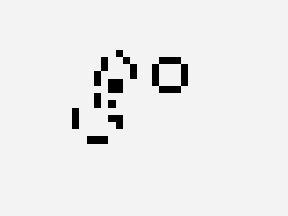
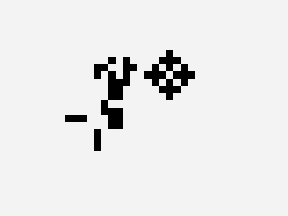
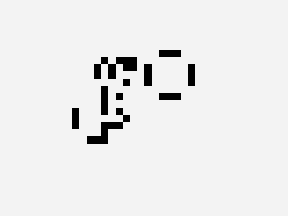
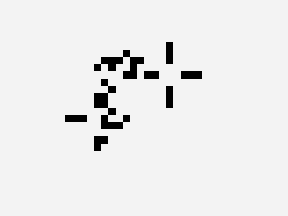
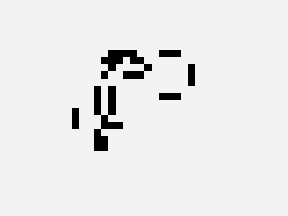
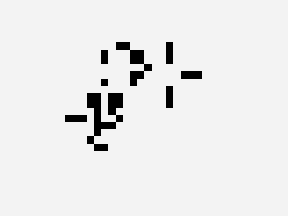
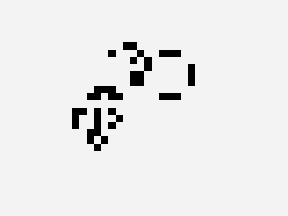
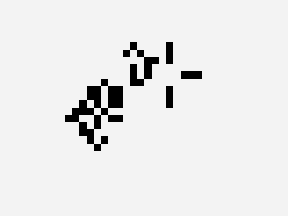
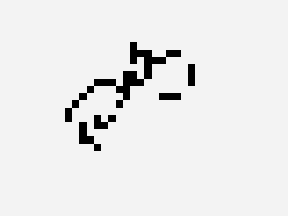
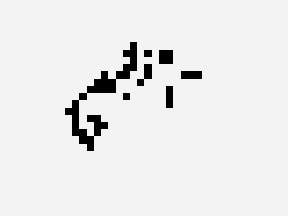
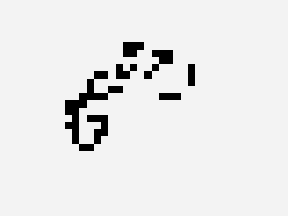
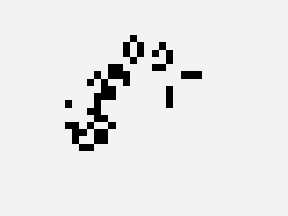
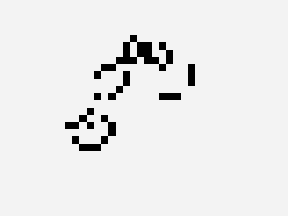
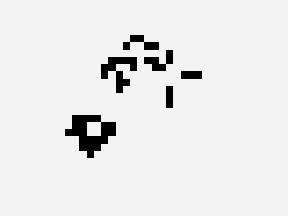
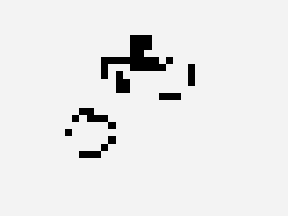
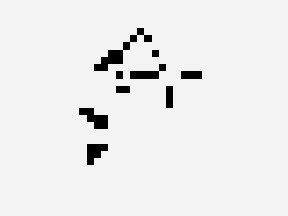
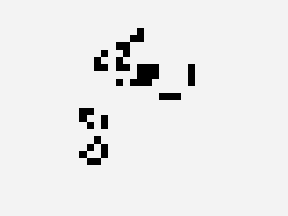
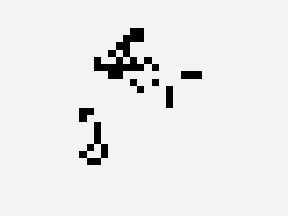
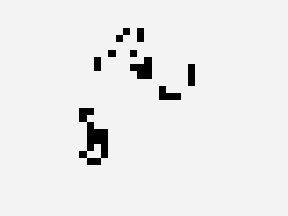
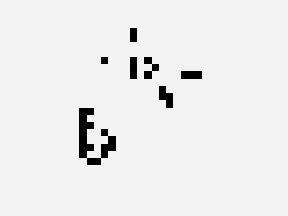
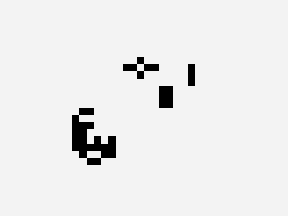
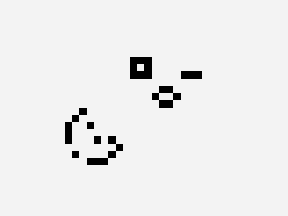
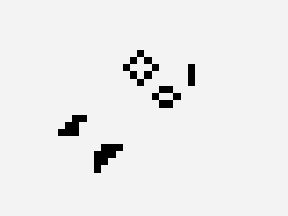
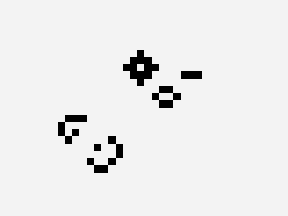
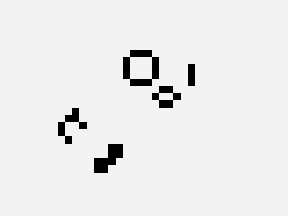
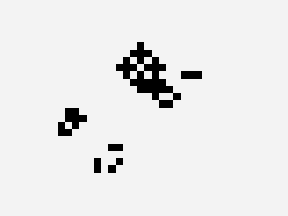
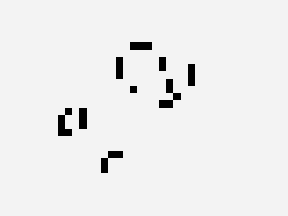
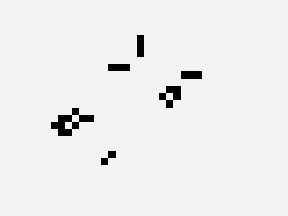
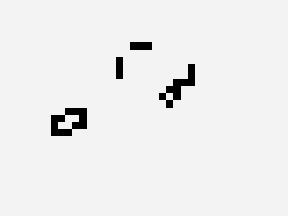
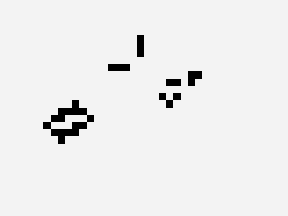
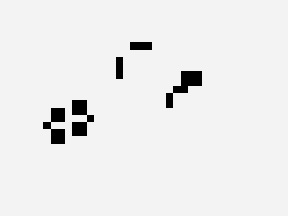
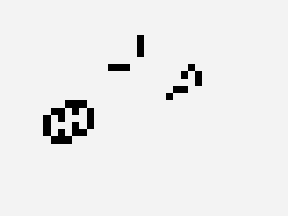
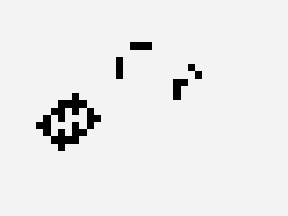
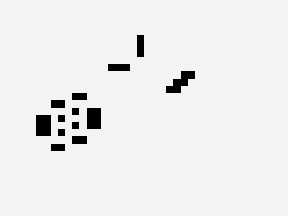
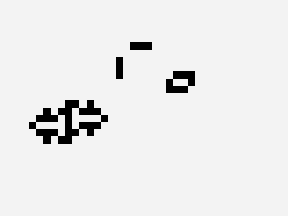
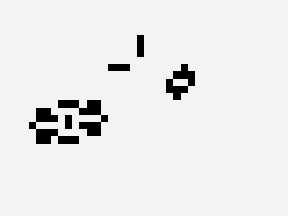
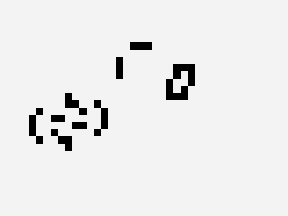
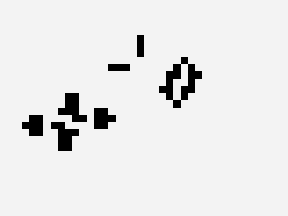
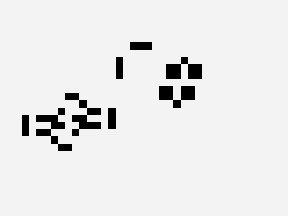
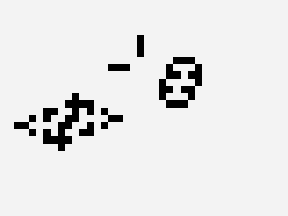
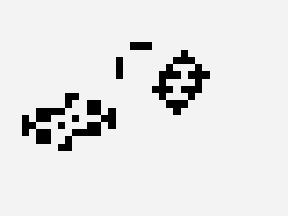
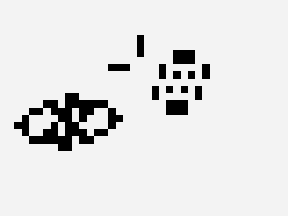
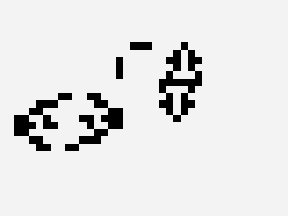
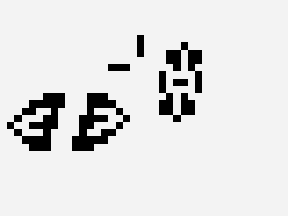
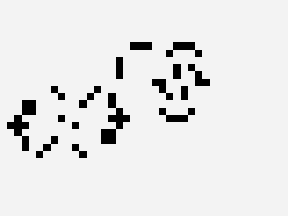
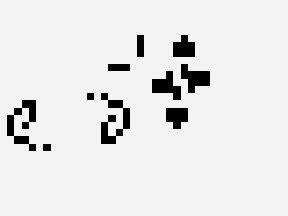
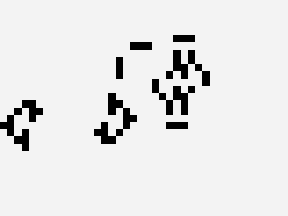
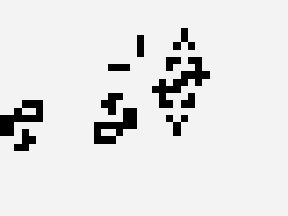
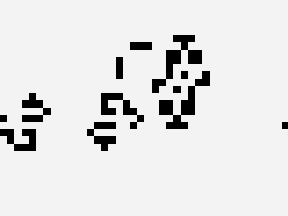
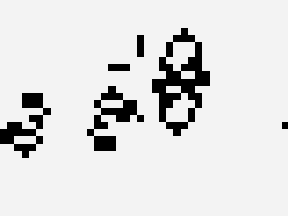
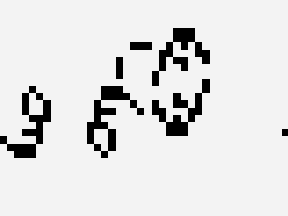
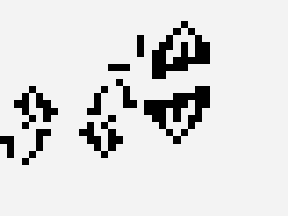
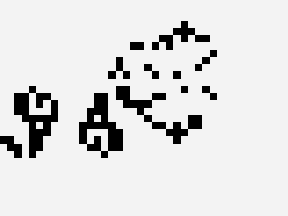
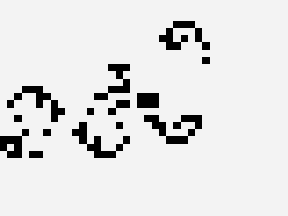
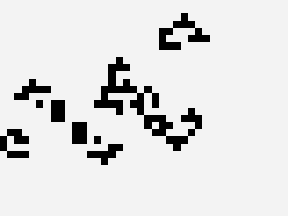
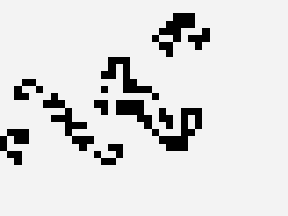
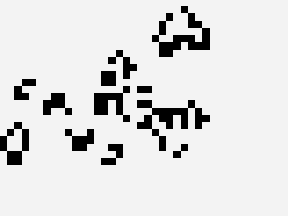
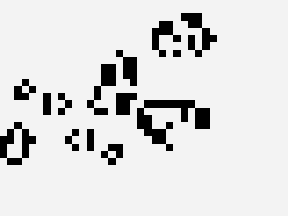
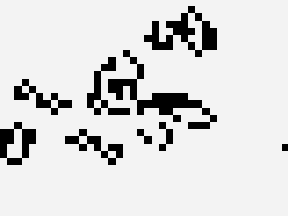
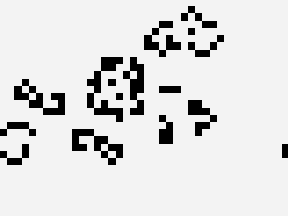
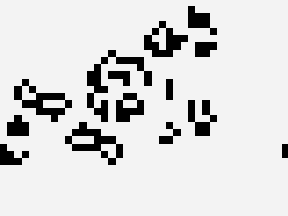
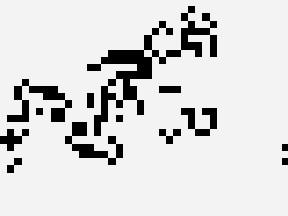
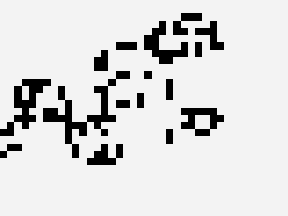
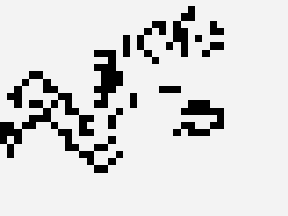
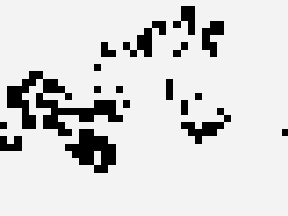
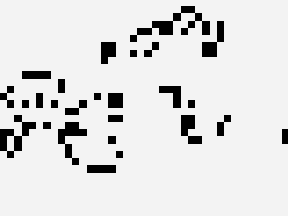
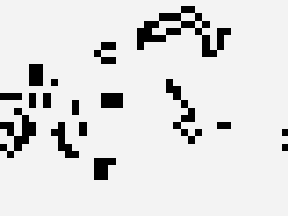

In [22]:
np.random.seed(2048)
X = np.zeros((30, 40), dtype=bool)
r = np.random.random((10, 20))
X[10:20, 10:30] = (r > 0.75)
life_animation(X, dpi=10, frames=100, mode='once')

With the above random seed (0), the cells die off after about 40 generations. In the process, some very interesting patterns show up: there are static patterns, oscillating patterns, and a lot of spontaneous symmetry. Let's explore with different random seeds and animation parameters.

## Static Configurations
Several static configurations are known: some of the smallest static units are shown here. We'll generate a few frames just to show that they are in fact static:


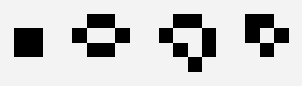
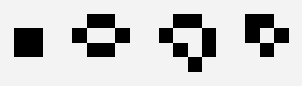
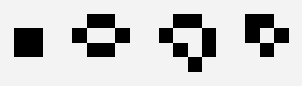

In [10]:
X = np.zeros((6, 21))

X[2:4, 1:3] = 1

X[1:4, 5:9] = [[0, 1, 1, 0],
               [1, 0, 0, 1],
               [0, 1, 1, 0]]

X[1:5, 11:15] = [[0, 1, 1, 0],
                 [1, 0, 0, 1],
                 [0, 1, 0, 1],
                 [0, 0, 1, 0]]

X[1:4, 17:20] = [[1, 1, 0],
                 [1, 0, 1],
                 [0, 1, 0]]

life_animation(X, dpi=5, frames=3)

##Some Simple Oscillators (The "Blinker" and the "Toad")

An _oscillator_ is a pattern that returns to its initial configuration after some number of steps. The static patterns shown above could be thought of as oscillators with a period of one. Here are two commonly-seen _period-two_ oscillators:


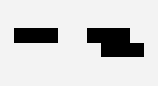
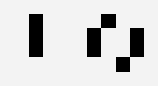
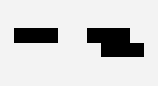
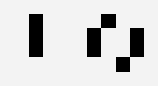

In [11]:
blinker = [1, 1, 1]

toad = [[1, 1, 1, 0],
        [0, 1, 1, 1]]

X = np.zeros((6, 11))

X[2, 1:4] = blinker
X[2:4, 6:10] = toad

life_animation(X, dpi=5, frames=4)

##Another Oscillator: The "Pulsar"

More complicated oscillators exist. Here's a period-three oscillator known as _'The Pulsar'_, which displays some appealing symmetry:


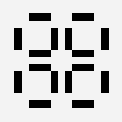
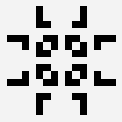
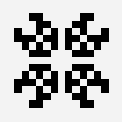
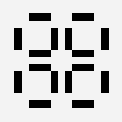
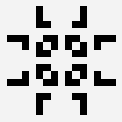
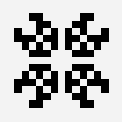

In [12]:
X = np.zeros((17, 17))
X[2, 4:7] = 1
X[4:7, 7] = 1
X += X.T
X += X[:, ::-1]
X += X[::-1, :]
life_animation(X, frames=6)

##The 'Glider'

There are other classes of object which oscillate, but also move while oscillating. One of the earliest seen is the _'Glider'_, which after 4 steps returns to its initial configuration, but shifted by one cell in both the x and y direction. This is a configuration that often emerges from random starting points.


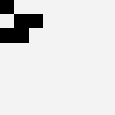
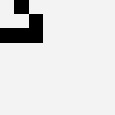
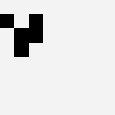
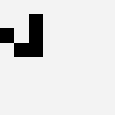
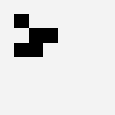
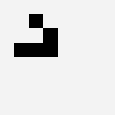
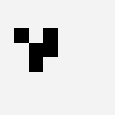
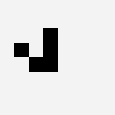
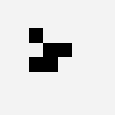
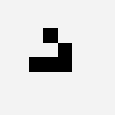
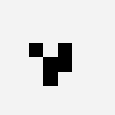
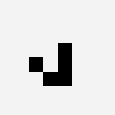
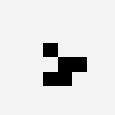
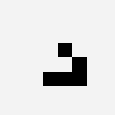
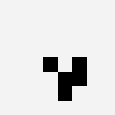
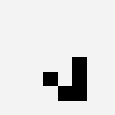
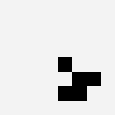
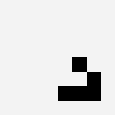
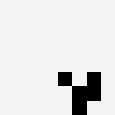
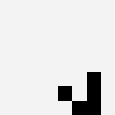
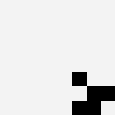
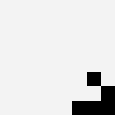
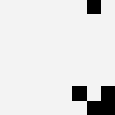
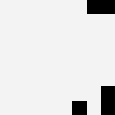
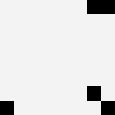
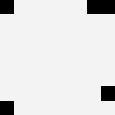
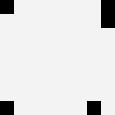
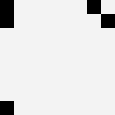
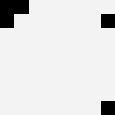
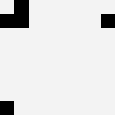
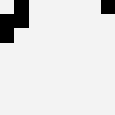
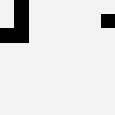

In [13]:
glider = [[1, 0, 0],
          [0, 1, 1],
          [1, 1, 0]]
X = np.zeros((8, 8))
X[:3, :3] = glider
life_animation(X, dpi=5, frames=32, interval=100)

##Infinite Growth

An early question posed about the Game of Life was whether any configurations exist which result in asymptotically infinite growth. It was quickly found that the answer was yes. Though it wasn't the first discovered, the following is one of the most compact configurations which display unbounded growth. Note that this claim is precisely true only on an infinite game board: using a torroidal (i.e. wrapping) geometry like we do here will lead to different results, but the first several hundred generations are unaffected:


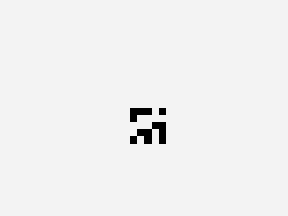
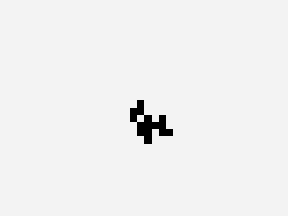
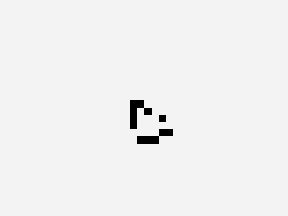
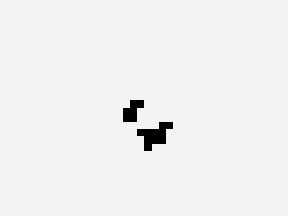
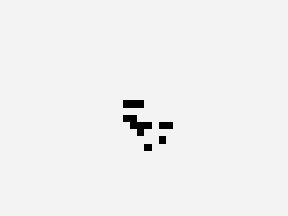
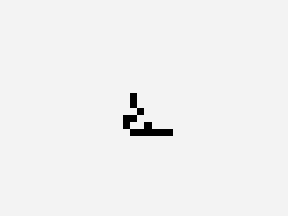
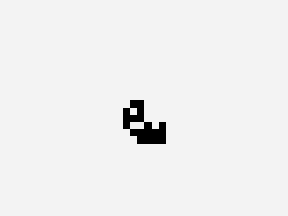
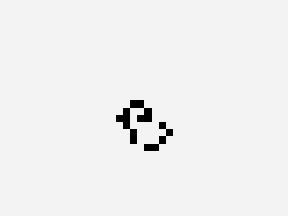
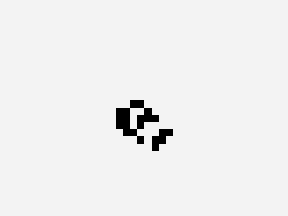
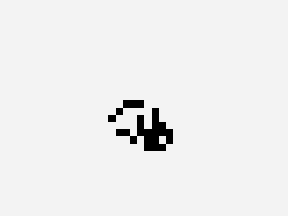
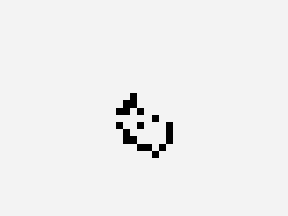
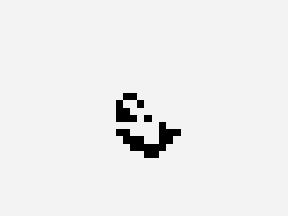
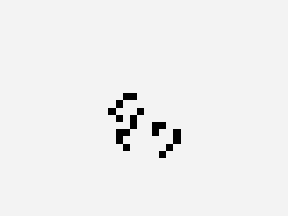
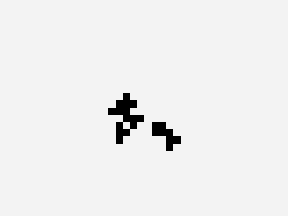
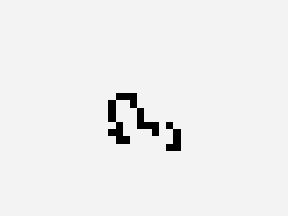
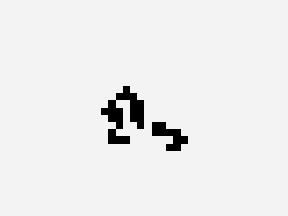
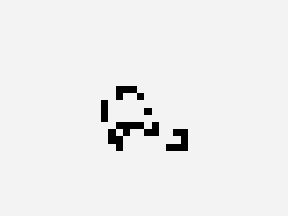
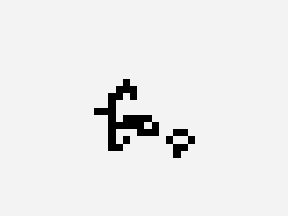
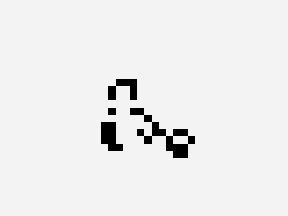
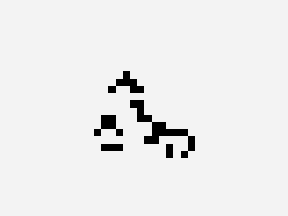
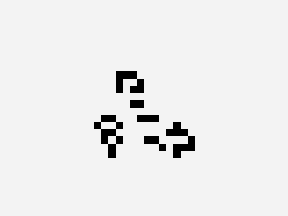
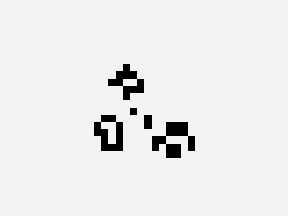
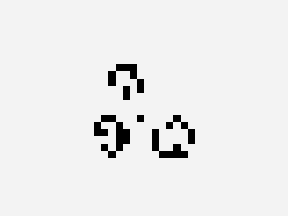
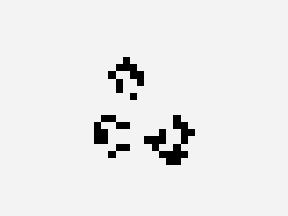
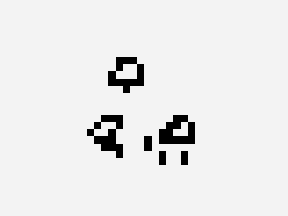
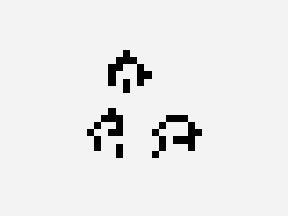
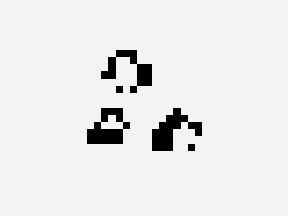
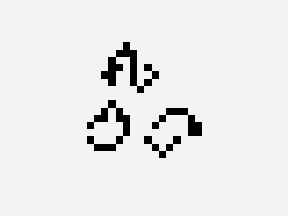
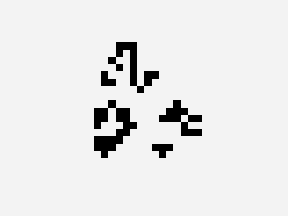
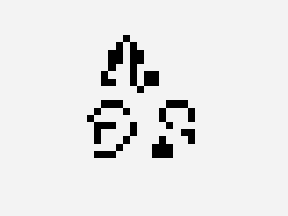
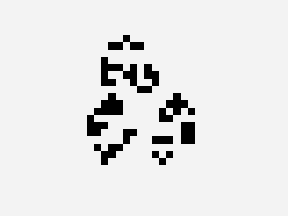
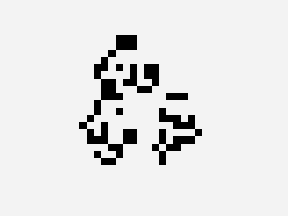
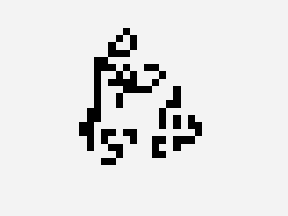
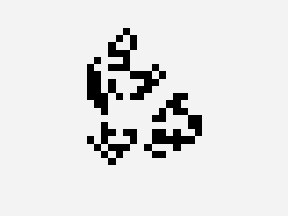
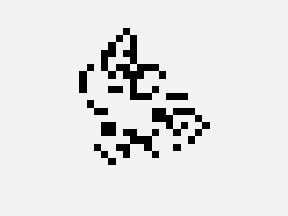
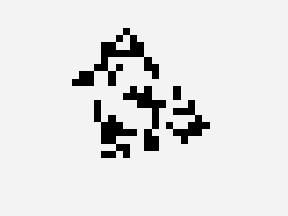
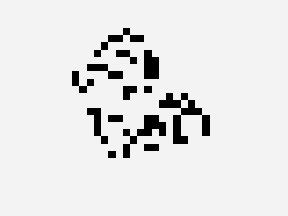
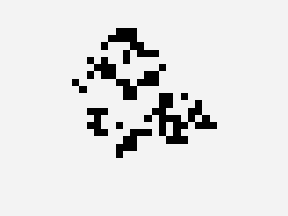
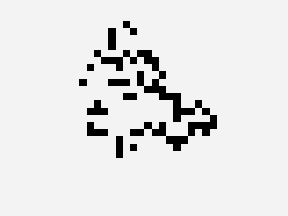
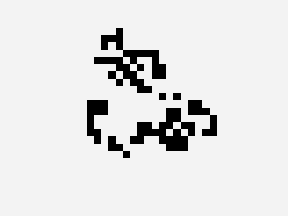
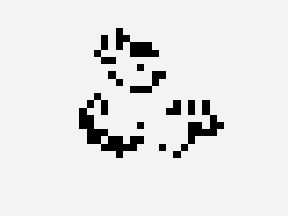
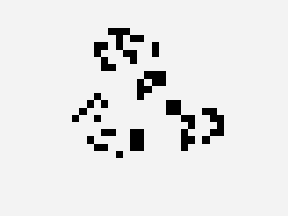
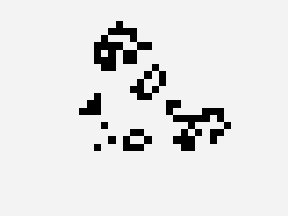
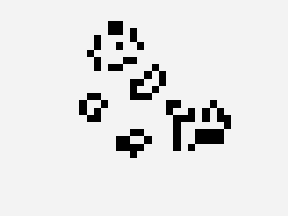
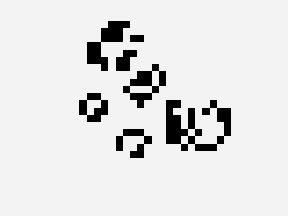
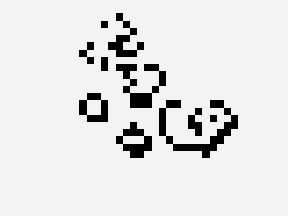
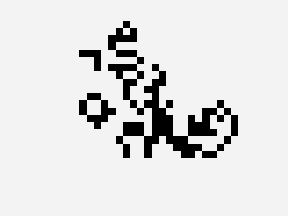
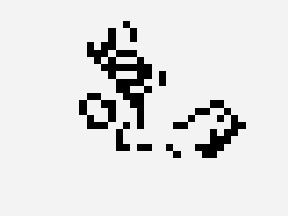
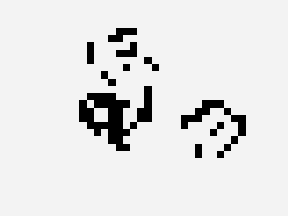
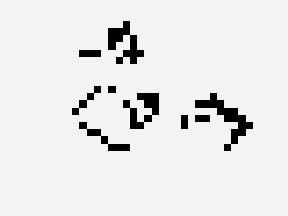
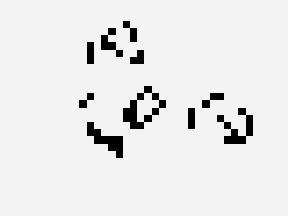
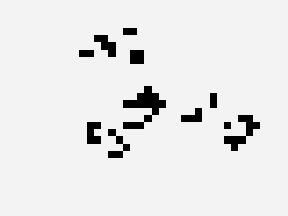
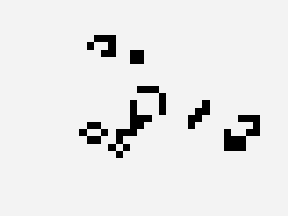
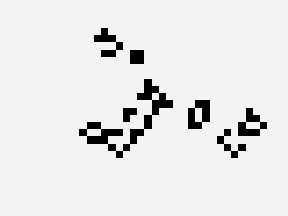
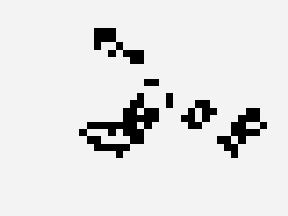
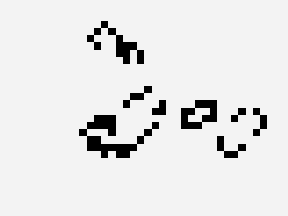
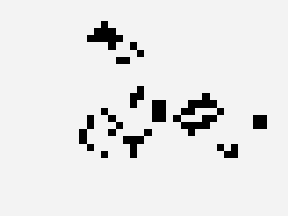
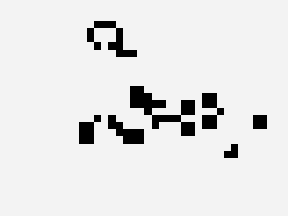
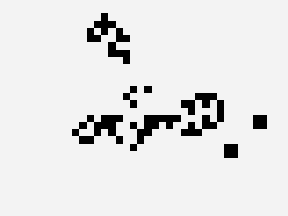
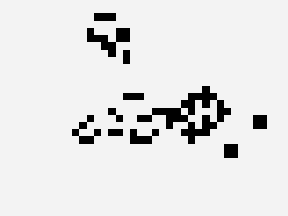
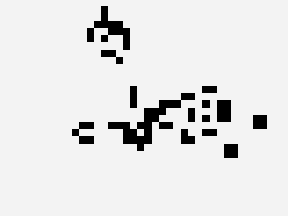
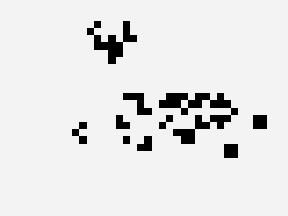
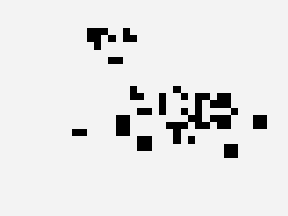
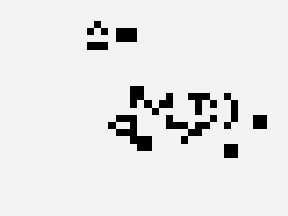
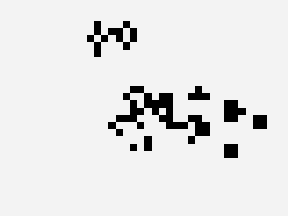
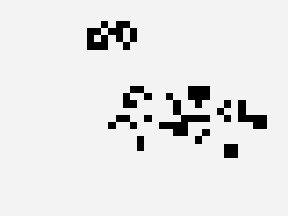
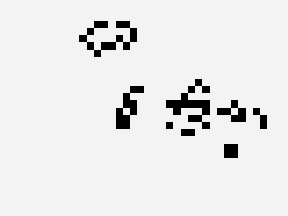
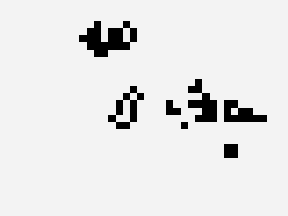
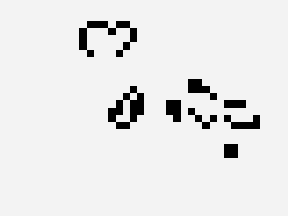
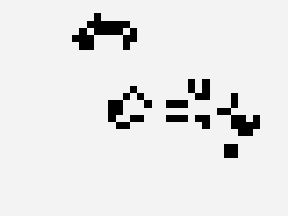
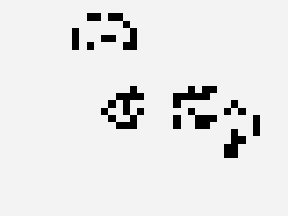
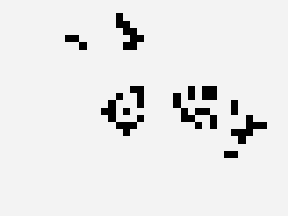
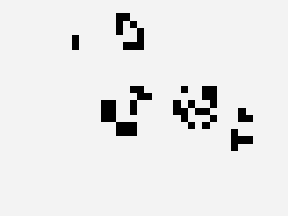
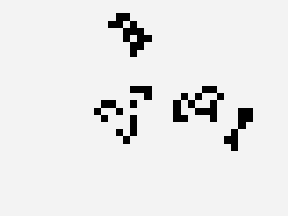
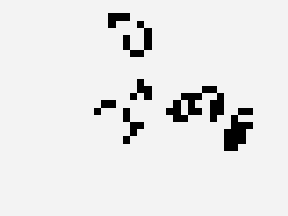
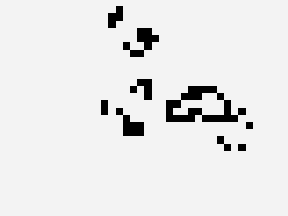
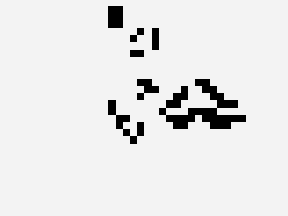
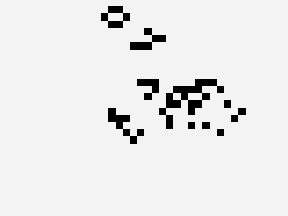
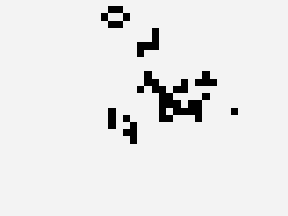
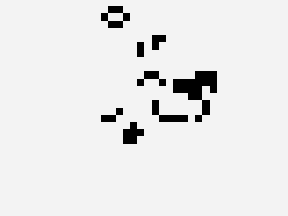
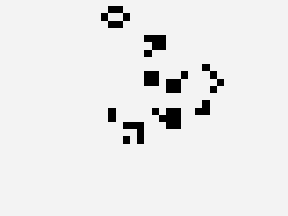
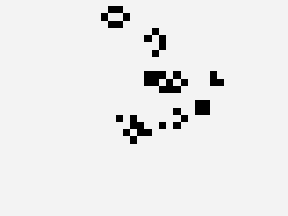
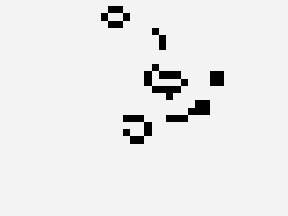
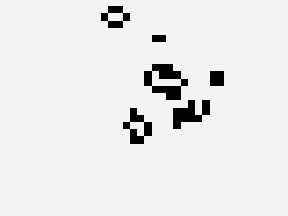
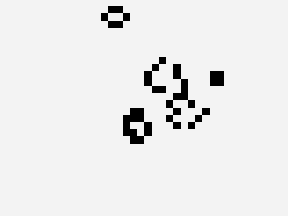
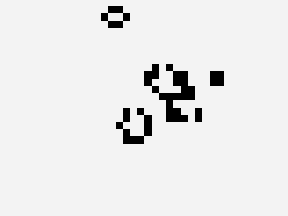
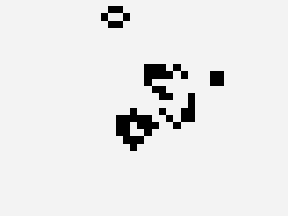
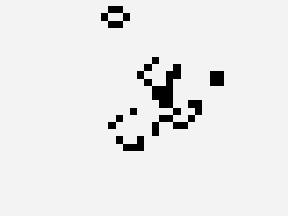
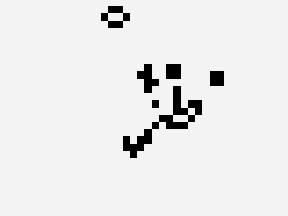
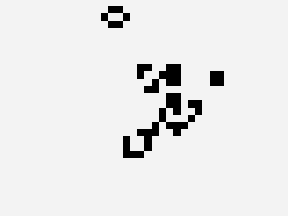
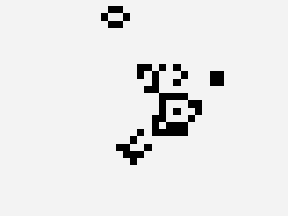
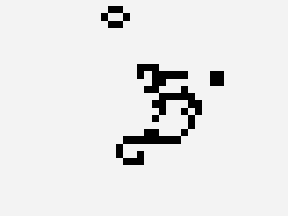
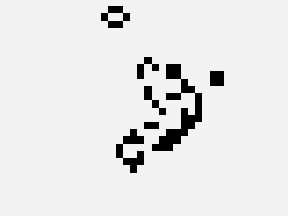
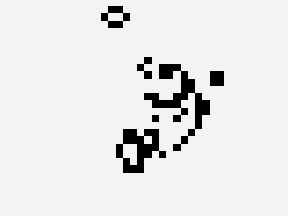
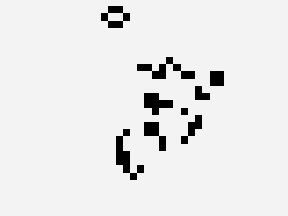
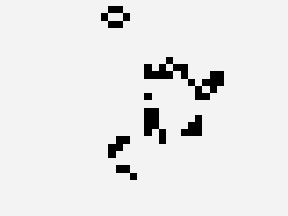
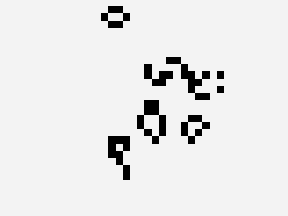
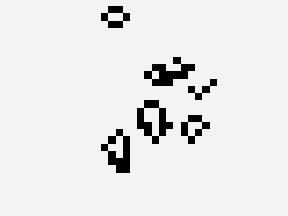
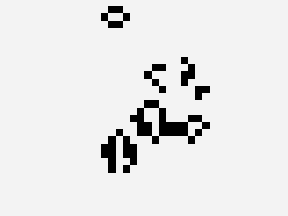
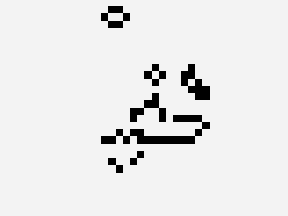

In [14]:
unbounded = [[1, 1, 1, 0, 1],
             [1, 0, 0, 0, 0],
             [0, 0, 0, 1, 1],
             [0, 1, 1, 0, 1],
             [1, 0, 1, 0, 1]]
X = np.zeros((30, 40))
X[15:20, 18:23] = unbounded
life_animation(X, dpi=10, frames=100, interval=200, mode='once')

##The 'Gosper Glider Gun'
The earliest known instance of infinite growth is one of the most interesting configurations: the _'Glider Gun'_ discovered by _Bill Gosper_. It is an oscillating pattern that creates an infinite series of gliders. It is really interesting that something like this can even emerge from Conway's simple rules, but here it is. We'll stop after a couple hundred frames, but given an infinite game board this action would go on forever:


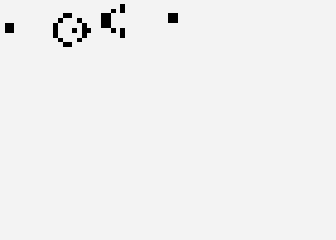
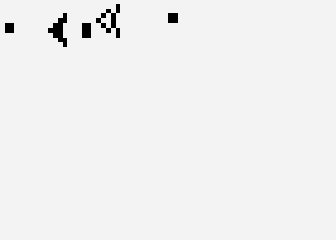
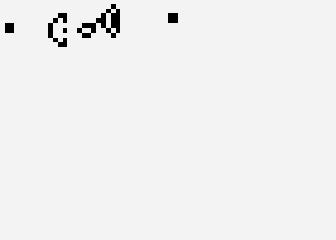
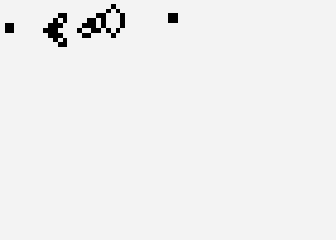
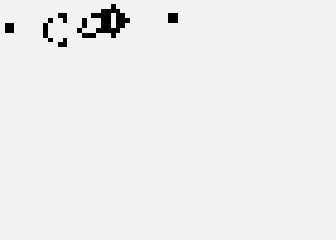
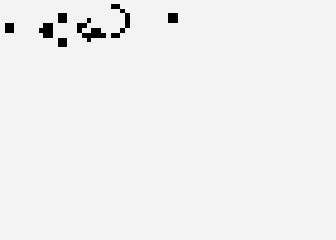
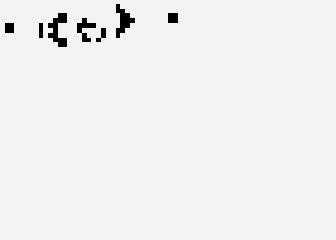
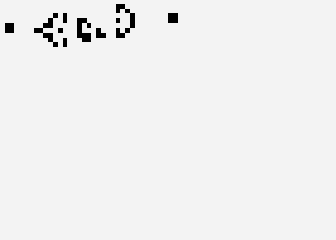
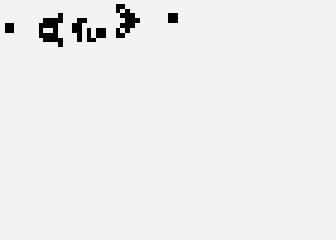
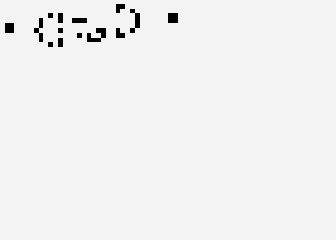
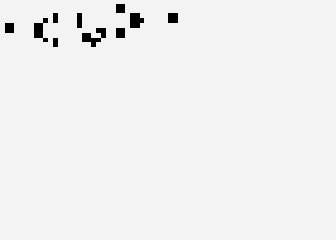
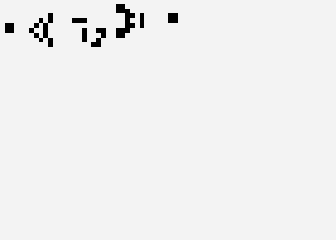
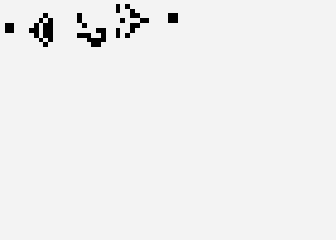
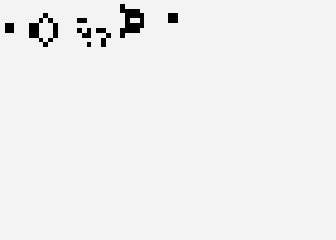
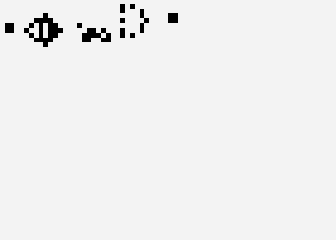
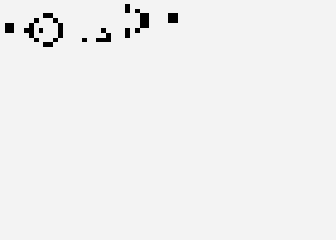
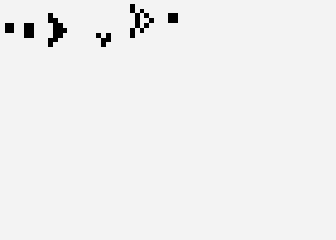
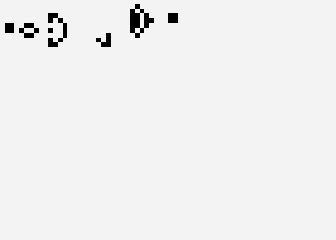
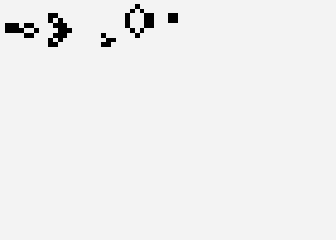
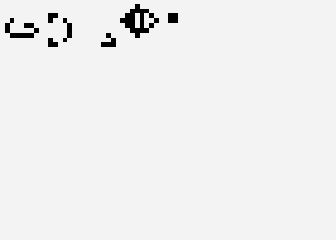
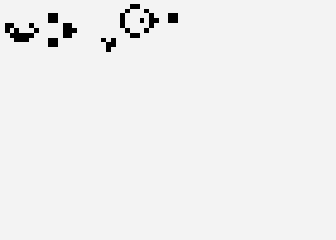
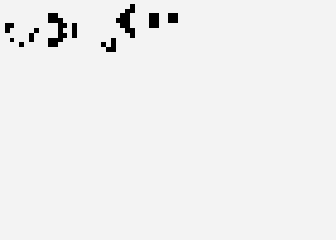
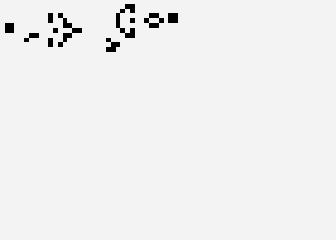
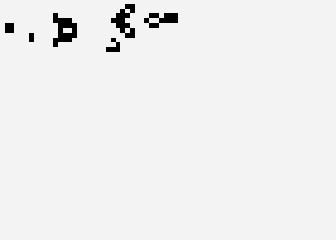
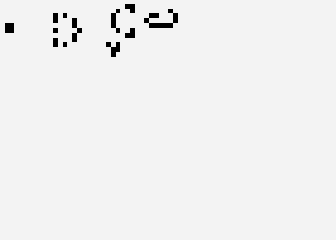
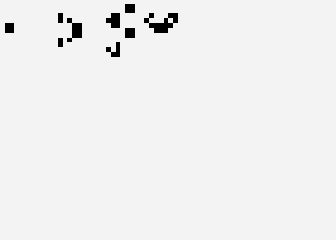
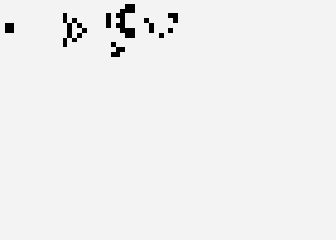
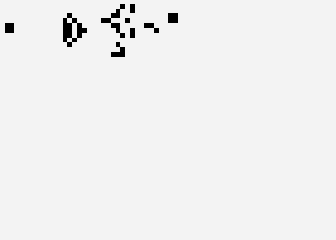
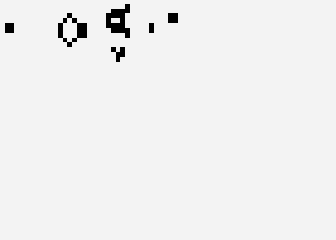
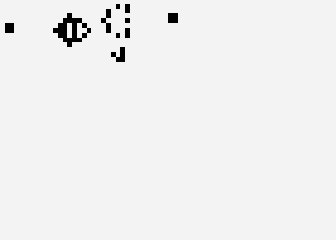
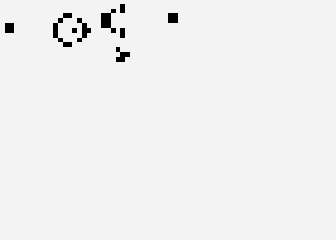
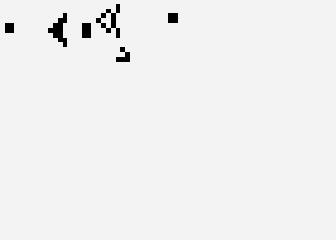
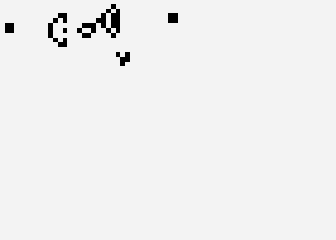
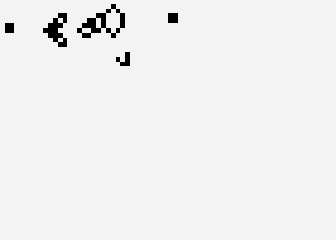
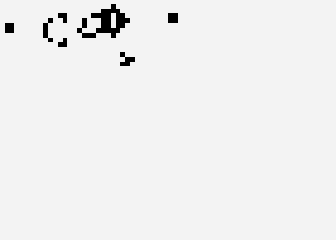
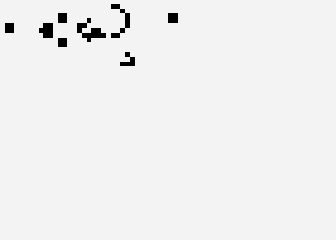
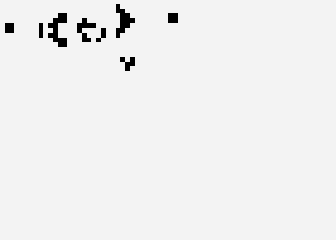
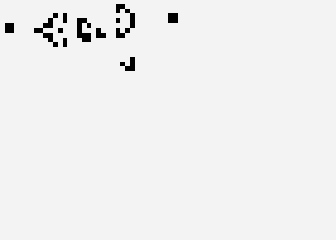
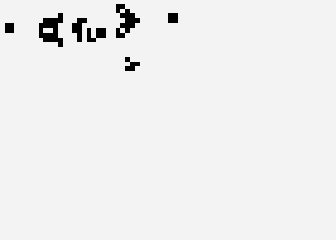
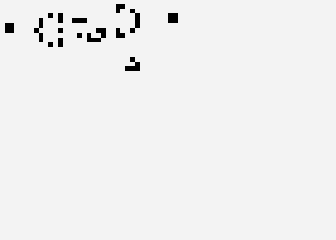
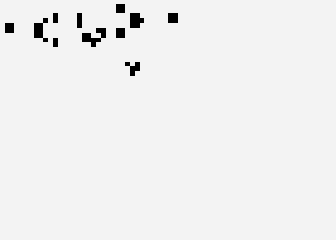
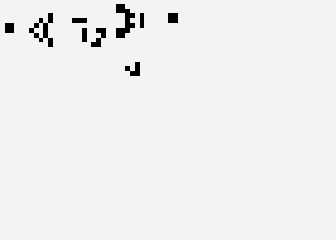
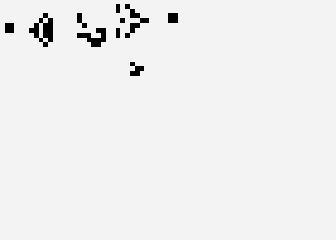
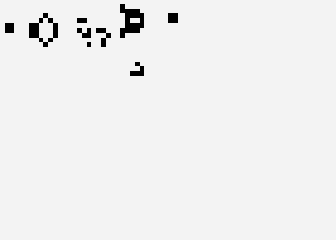
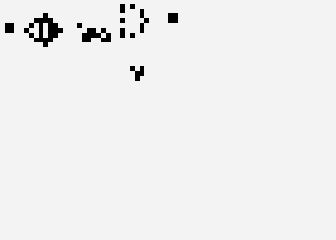
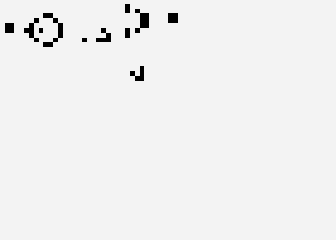
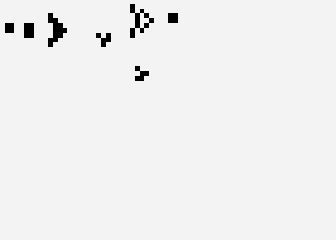
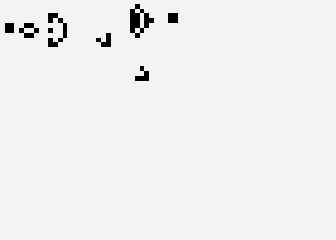
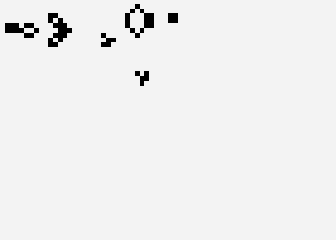
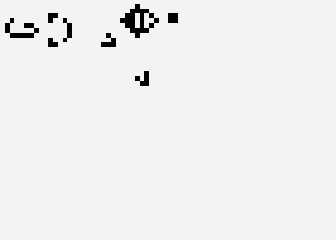
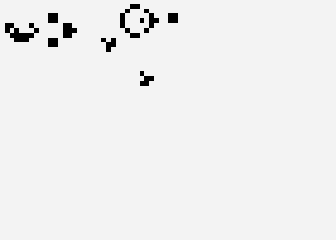
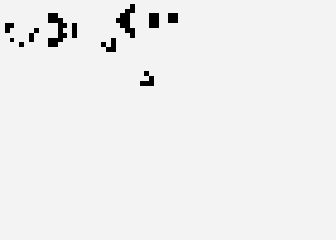
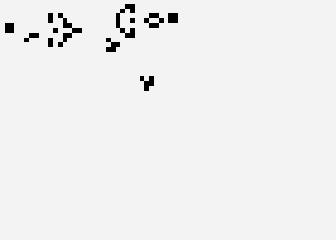
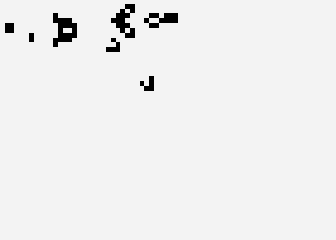
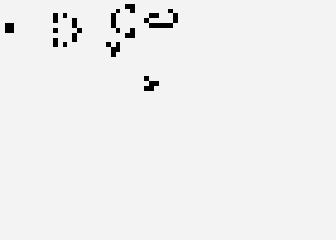
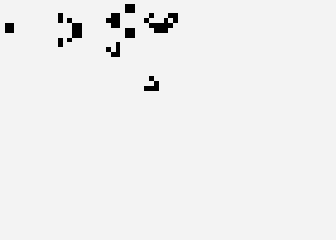
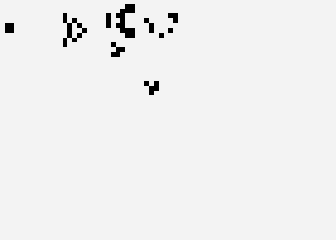
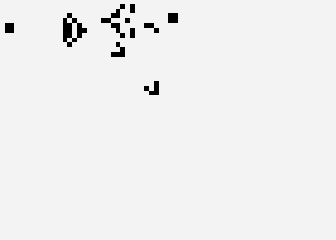
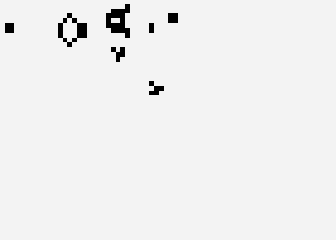
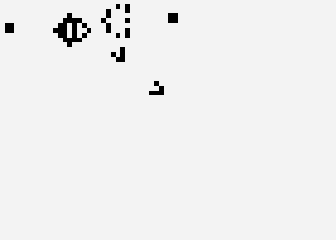
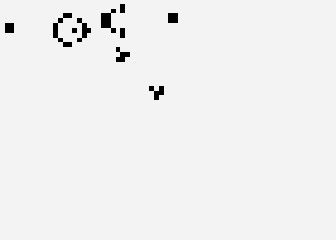
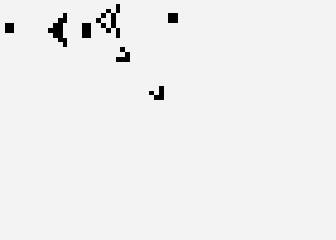
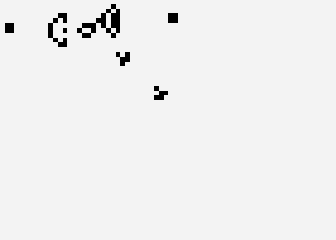
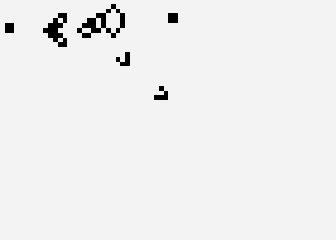
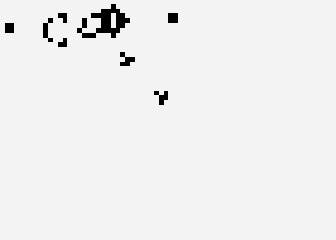
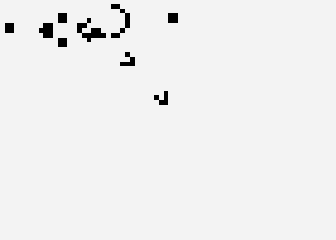
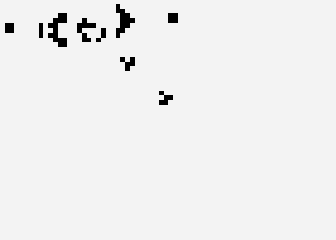
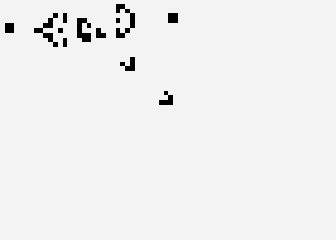
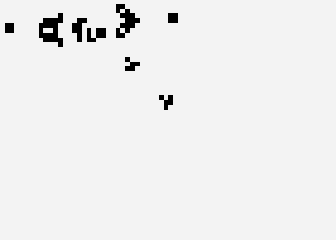
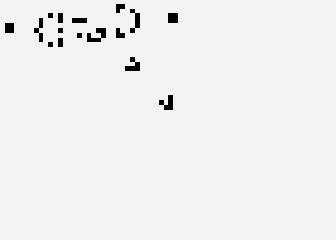
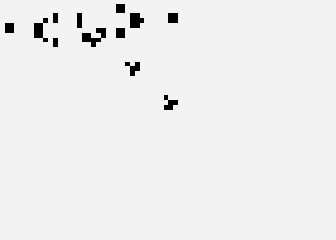
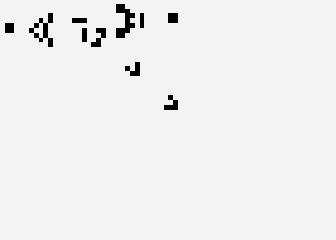
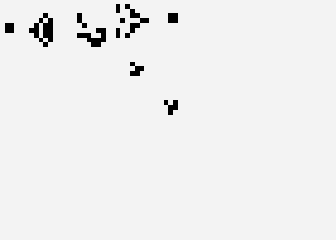
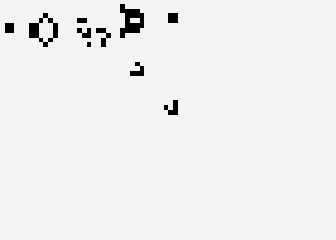
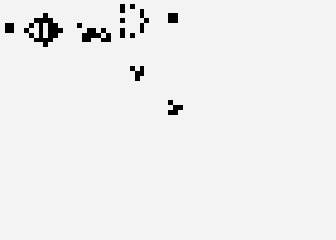
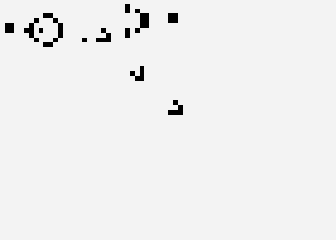
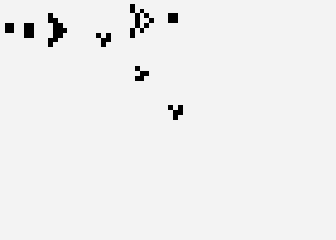
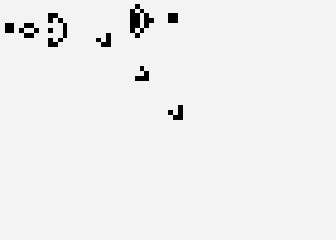
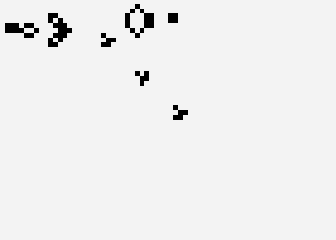
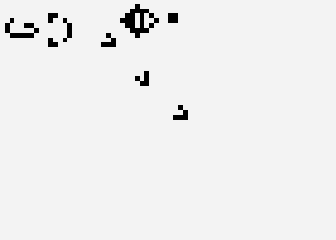
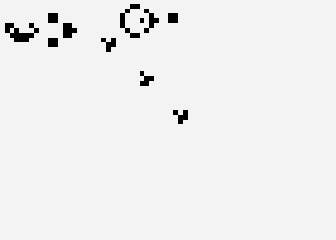
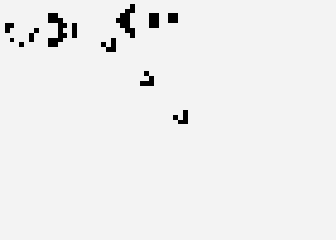
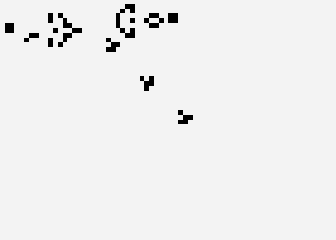
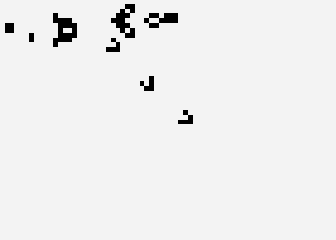
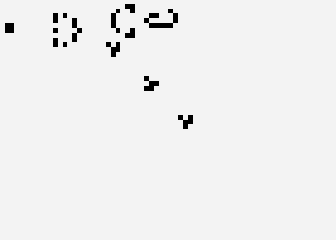
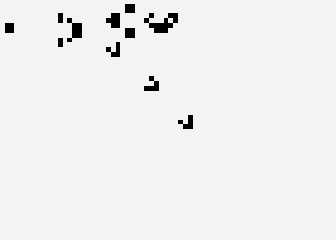
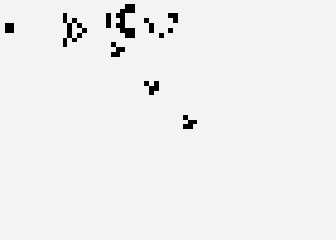
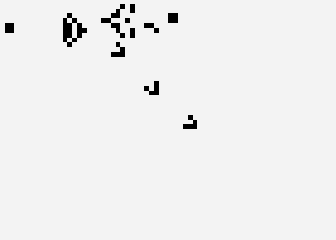
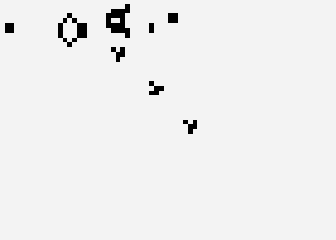
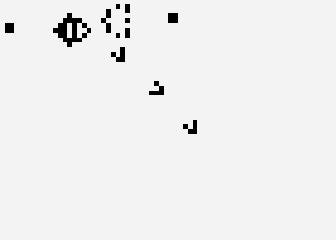
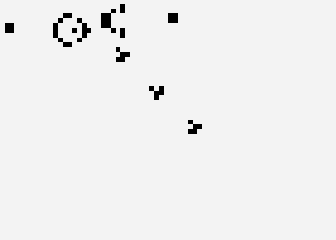
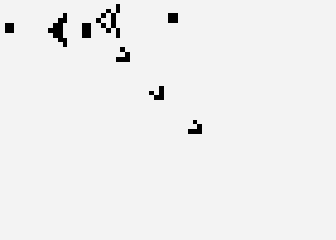
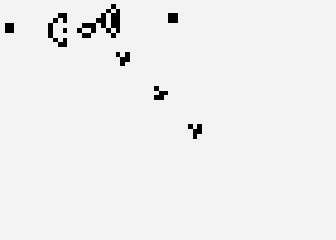
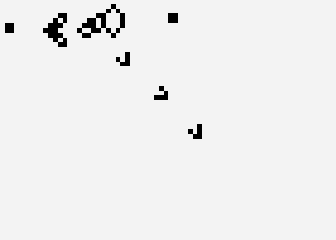
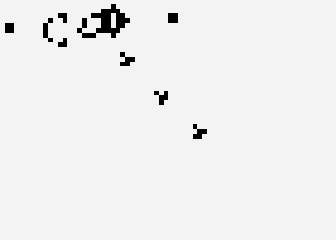
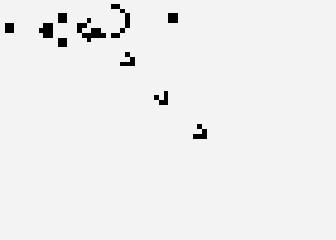
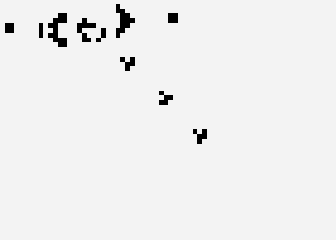
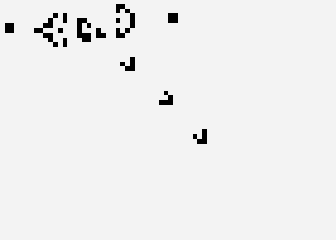
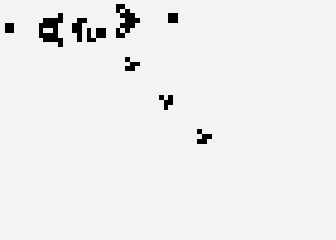
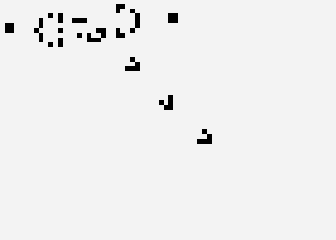
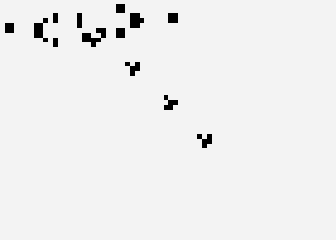
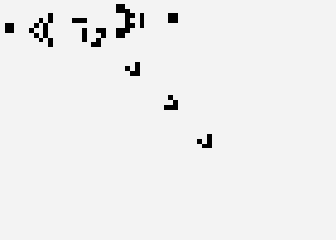
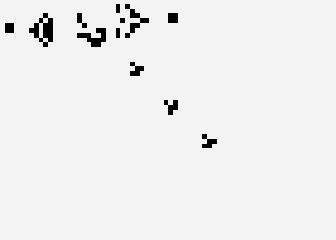
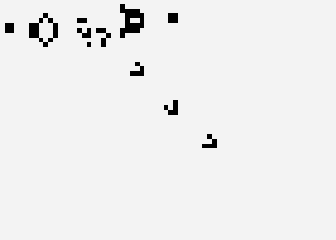
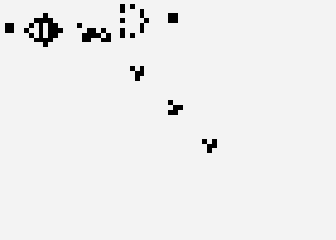
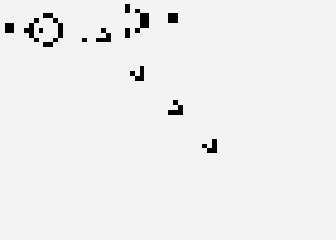
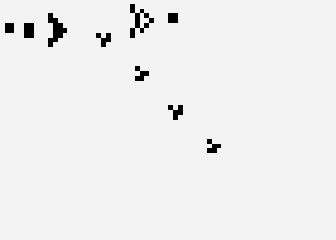
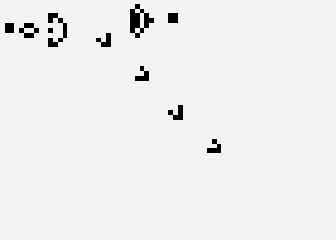
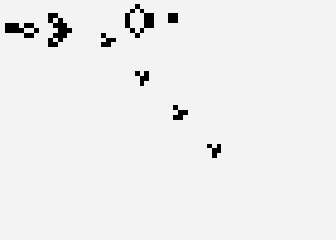
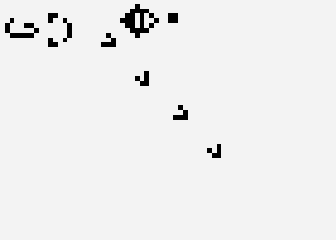
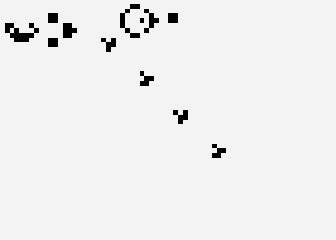
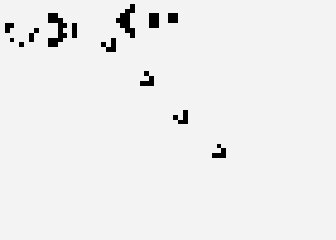
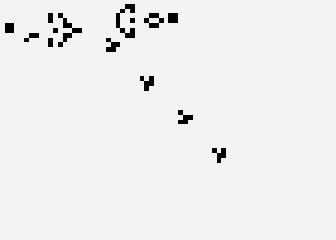
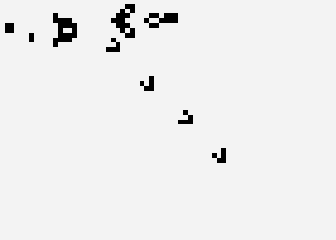
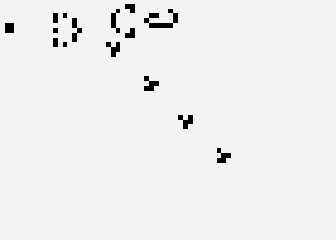
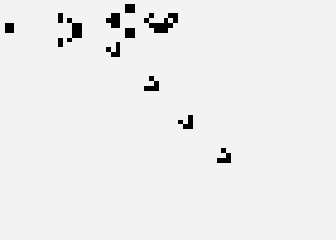
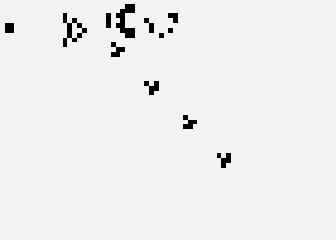
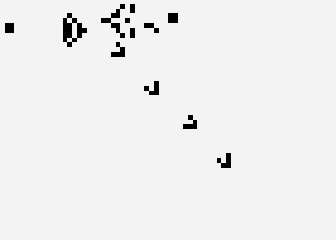
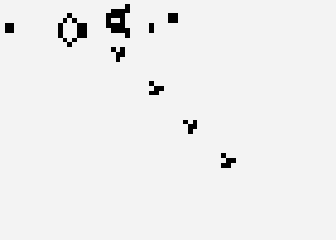
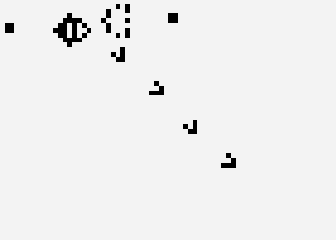
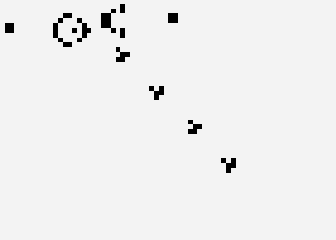
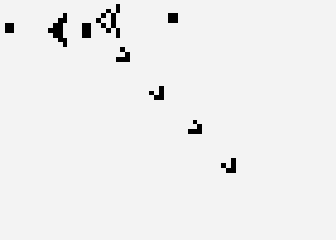
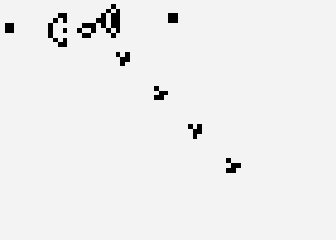
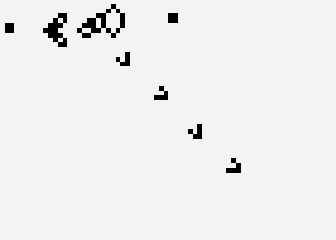
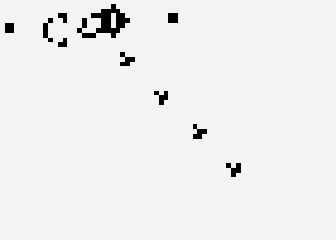
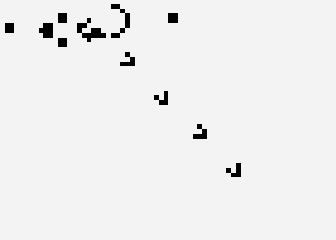
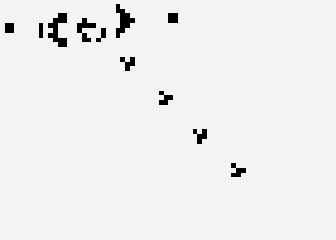
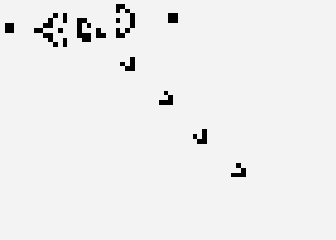
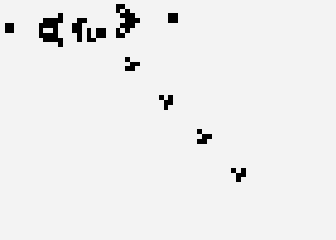
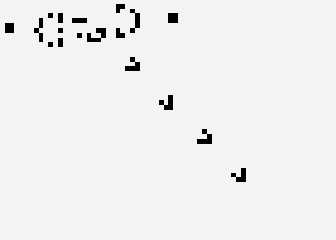
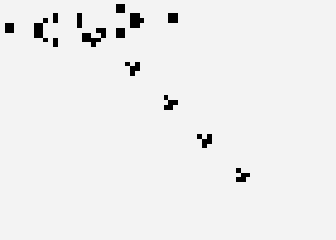
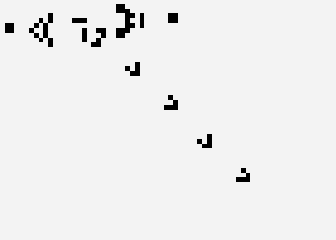
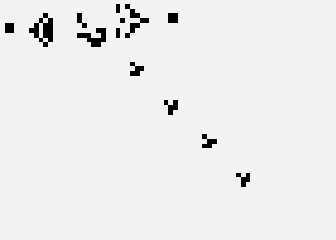
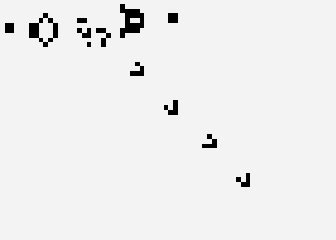
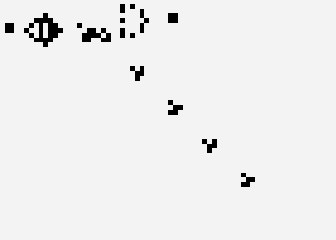
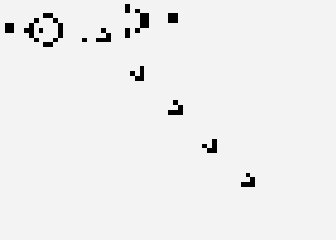
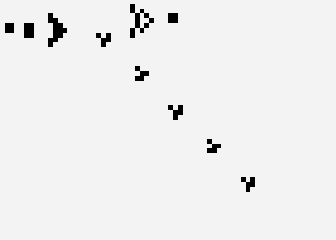
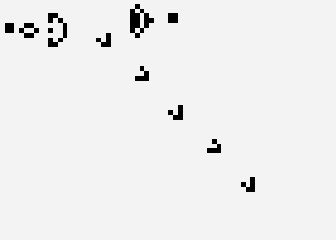
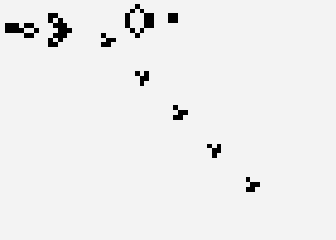
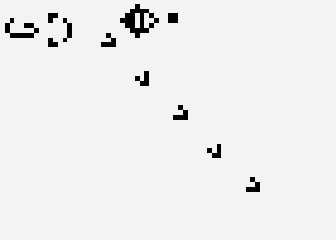
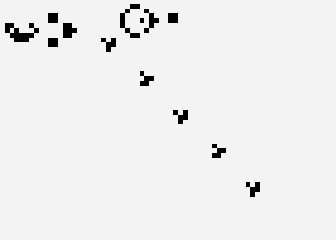
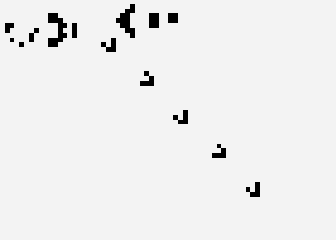
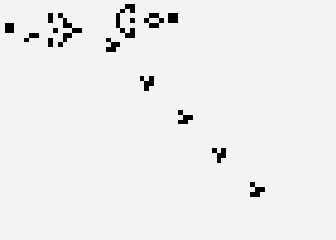
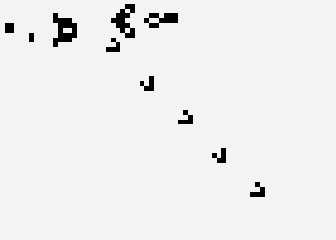
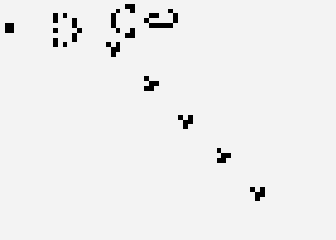
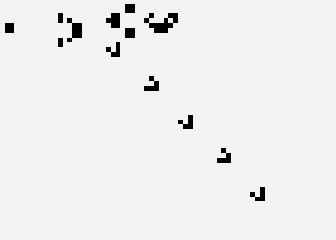
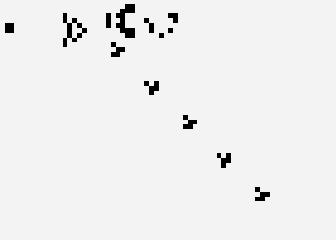
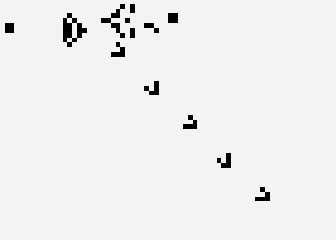
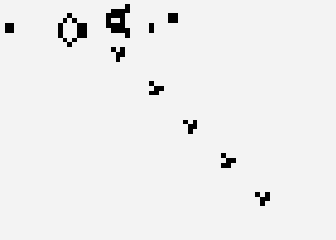
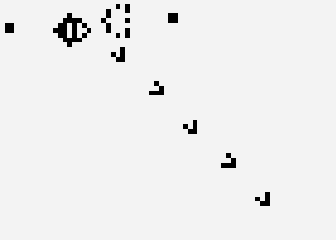
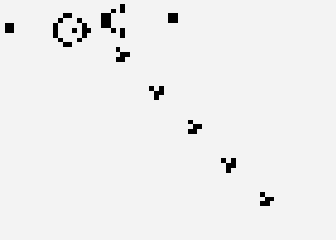
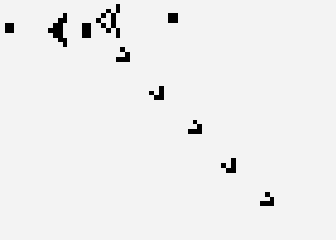
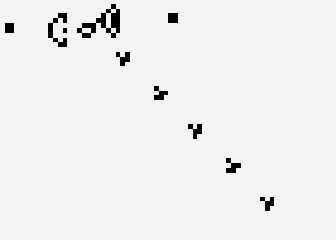
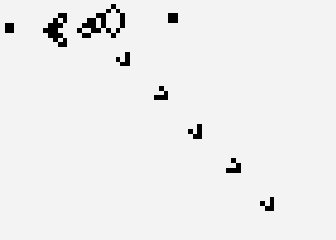
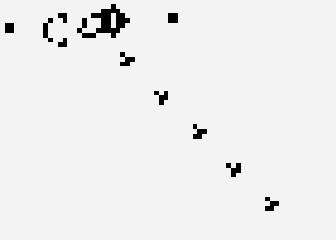
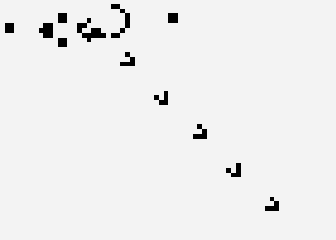
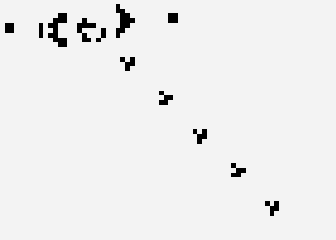
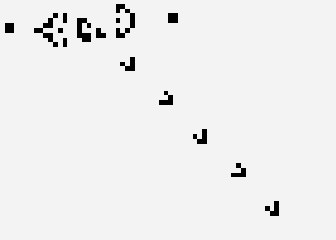
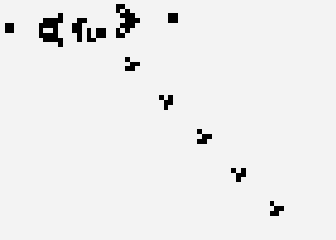
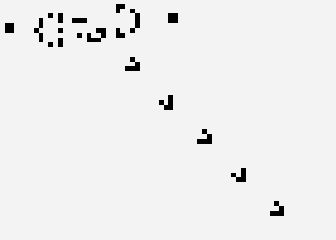
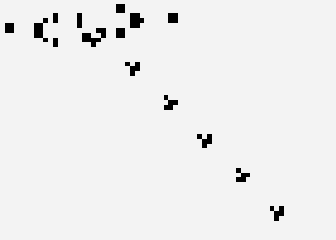
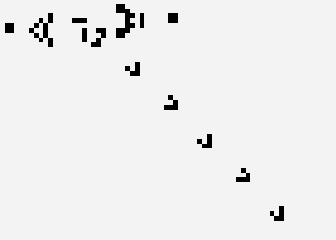
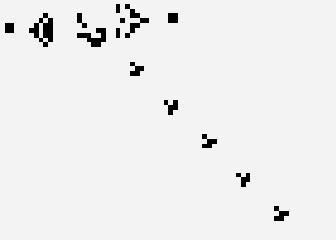
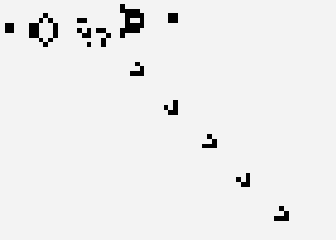
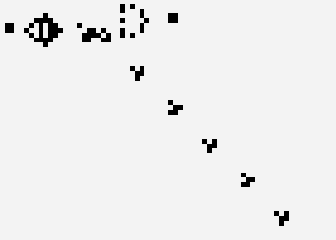
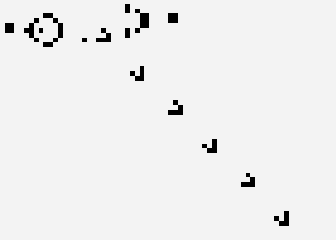
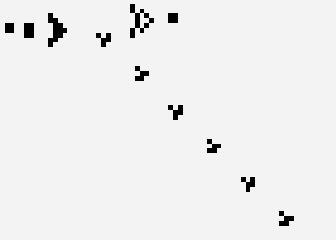
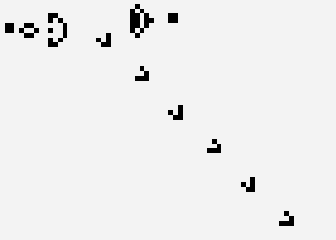
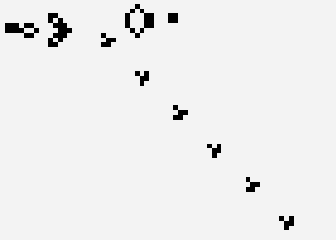
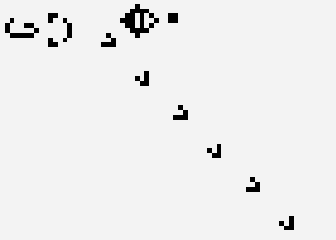
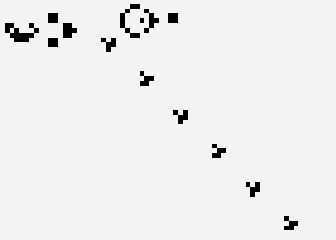
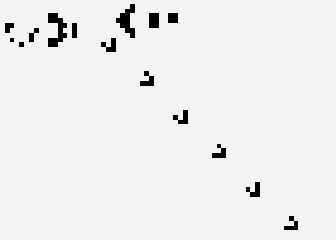
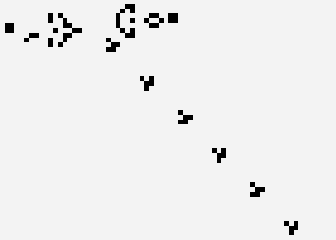
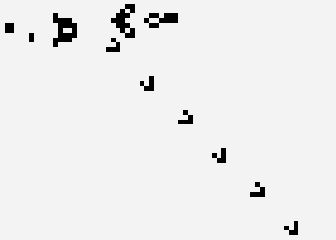
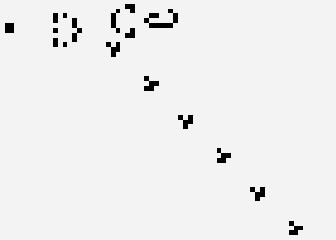
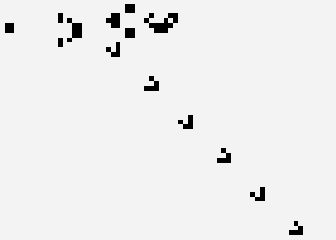
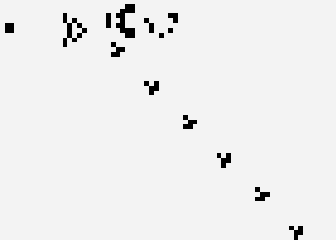
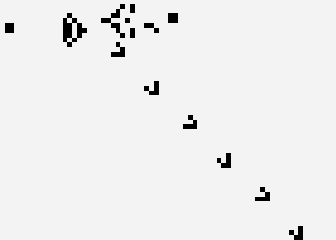
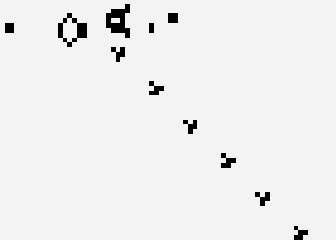
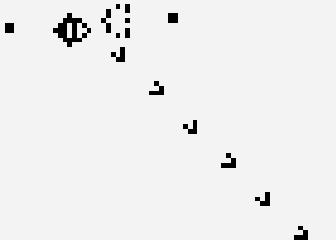

In [15]:
glider_gun =\
[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

X = np.zeros((50, 70))
X[1:10,1:37] = glider_gun

life_animation(X, dpi=15, frames=180, interval=50, mode='once')

##Going Further
Note that while the code above is well-suited for small explorations, it is probably not sufficient to do very large and long game of life computations. Despite (or perhaps because of) its simplicity, the Game of Life has inspired an entire community of people who study its properties. It has influenced fields as diverse as _mathematics_, _computer science_, _biology_, _epidemiology_, and _sociology_. This interest has led to the discovery of configurations with some very surprising properties. Incredibly, it has even been shown that a _Universal Turing Machine_ can be created within the rules of the game of life. That is, a computer which can compute game of life steps could, in theory, use this process to compute just about anything!


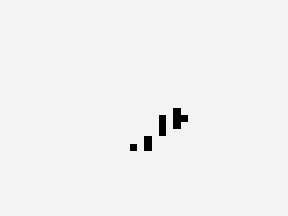
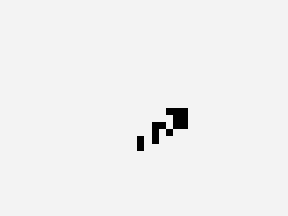
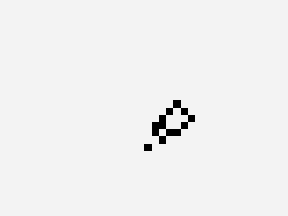
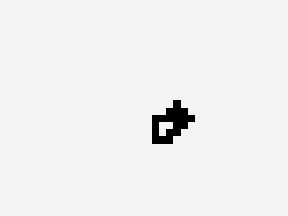
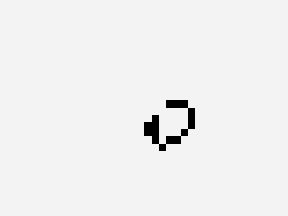
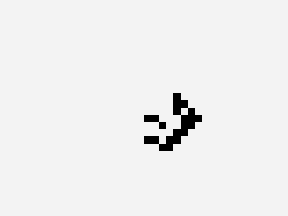
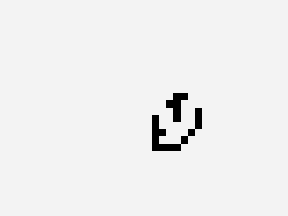
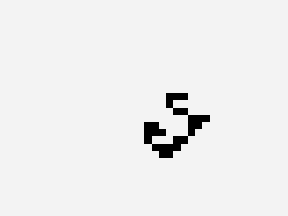
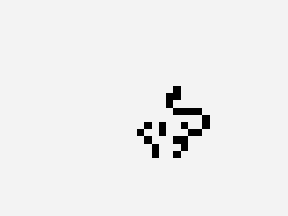
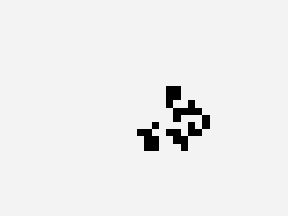
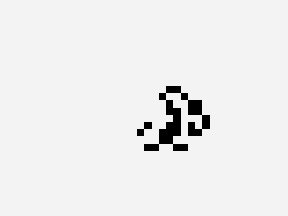
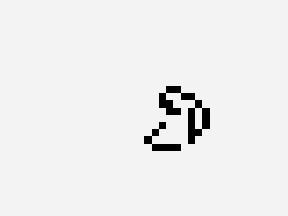
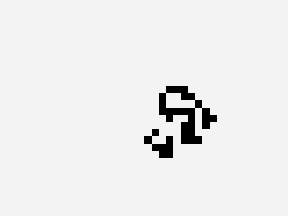
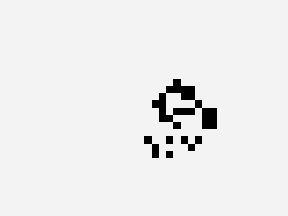
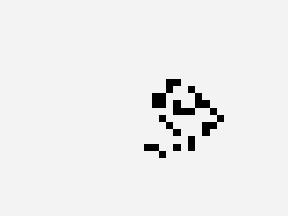
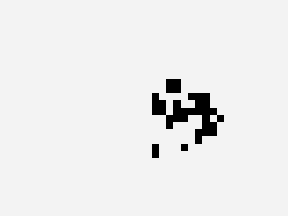
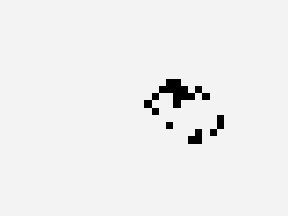
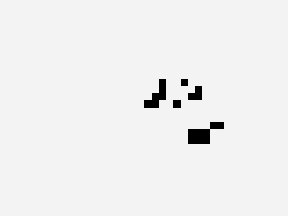
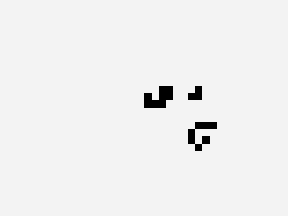
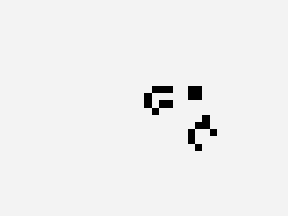
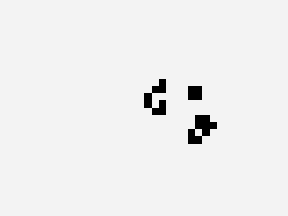
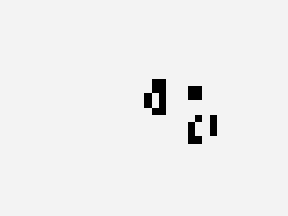
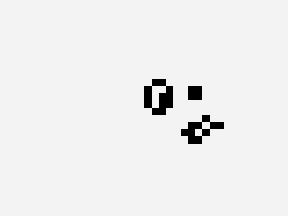
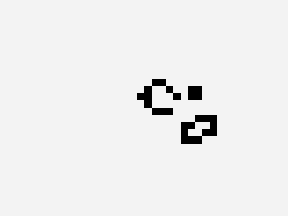
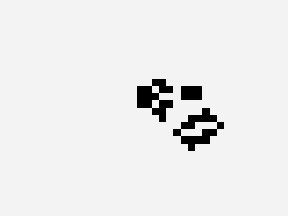
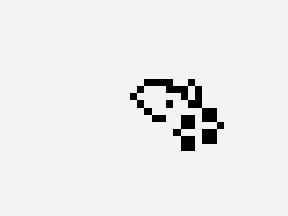
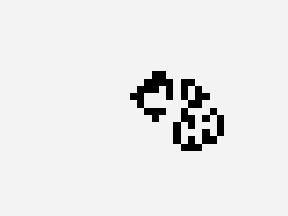
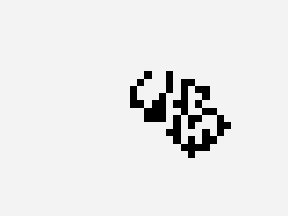
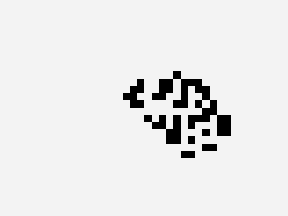
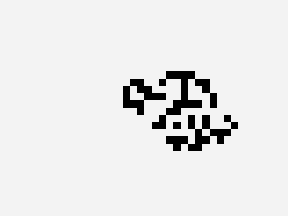
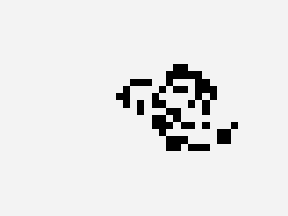
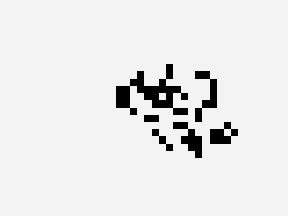
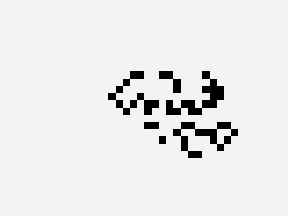
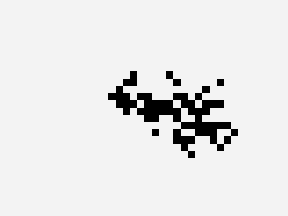
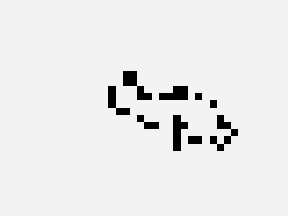
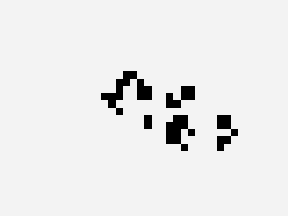
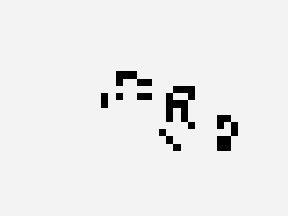
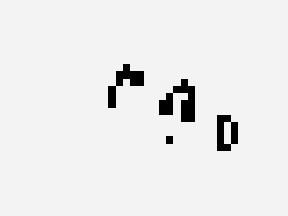
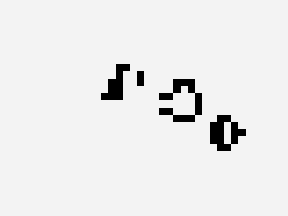
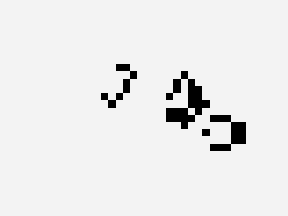
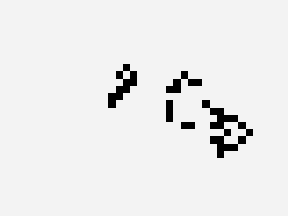
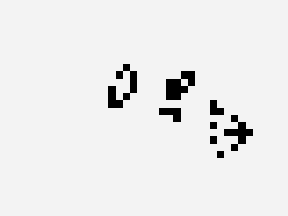
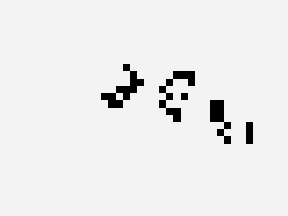
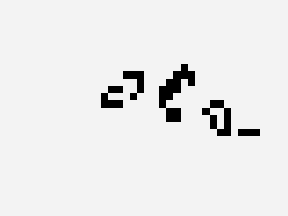
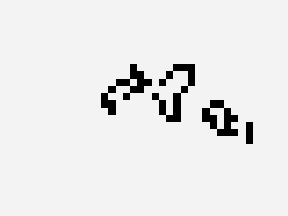
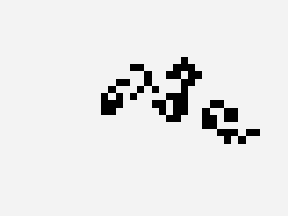
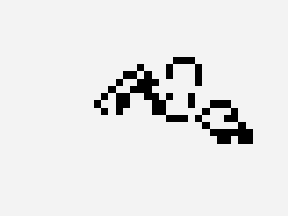
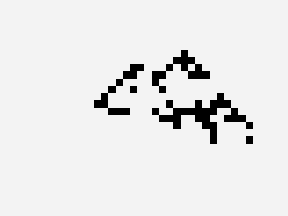
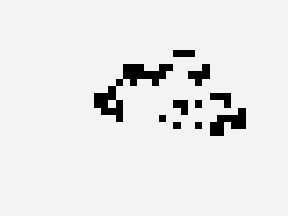
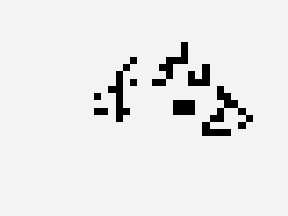
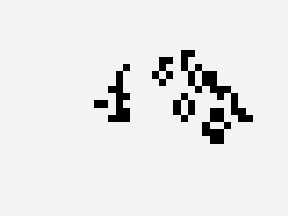
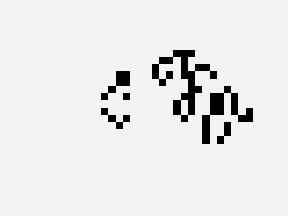
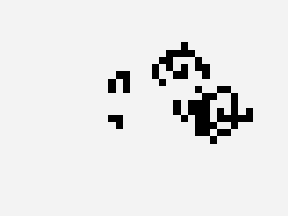
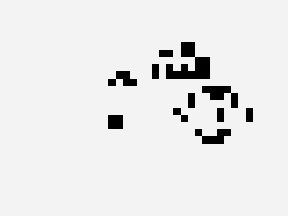
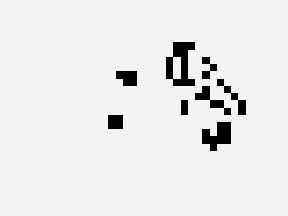
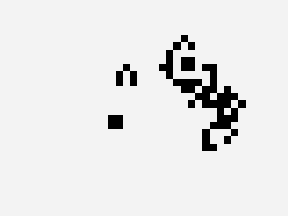
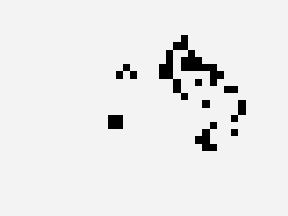
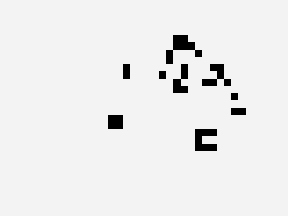
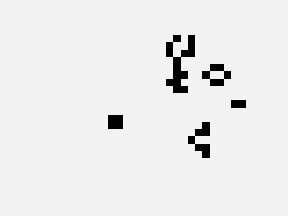
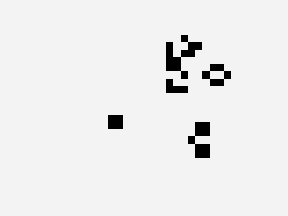
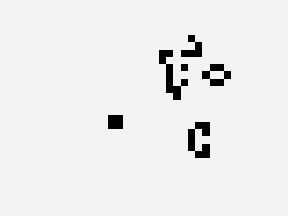
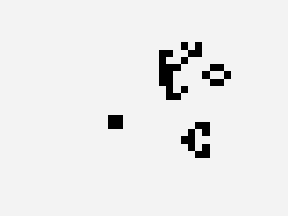
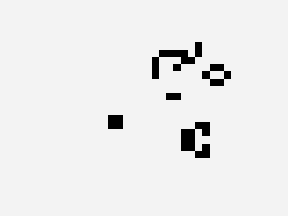
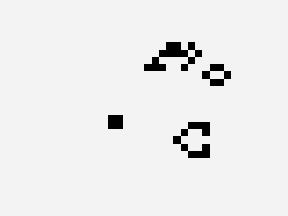
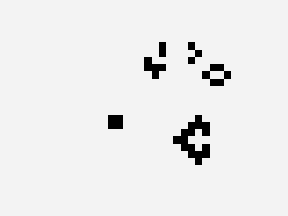
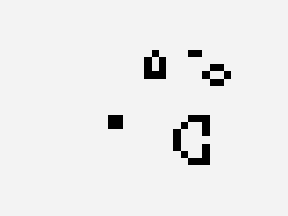
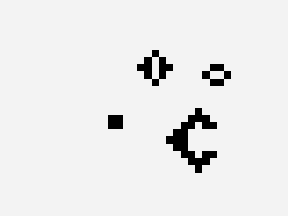
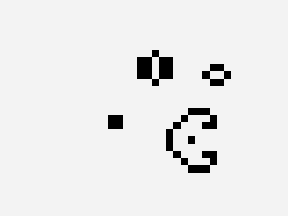
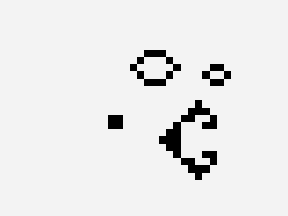
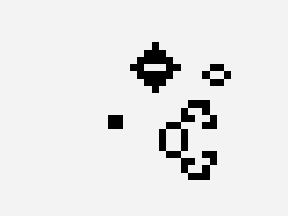
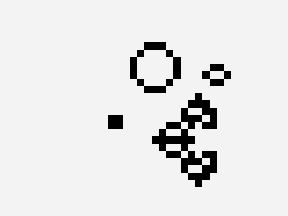
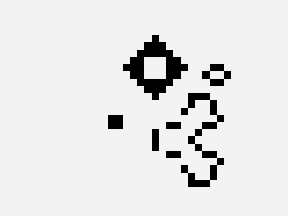
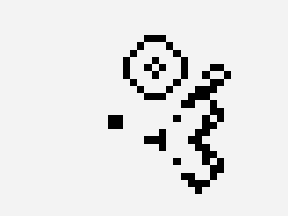
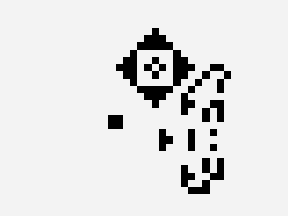
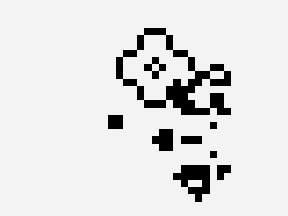
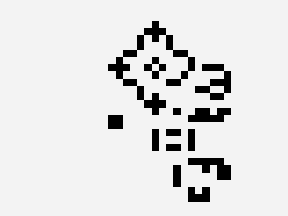
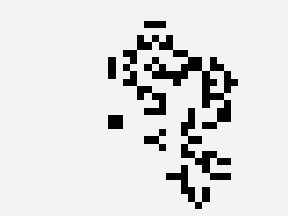
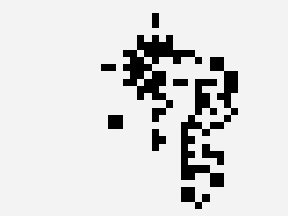
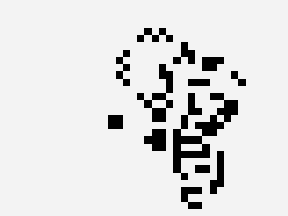
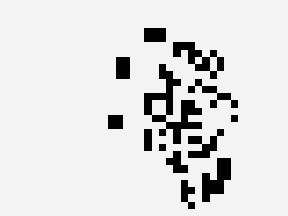
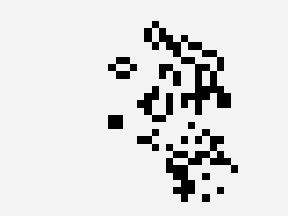
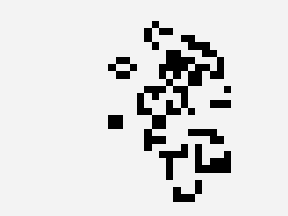
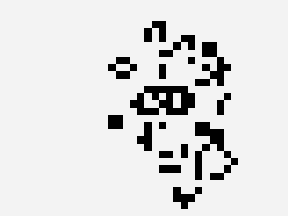
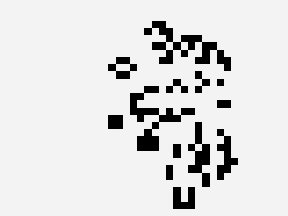
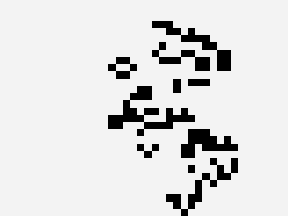
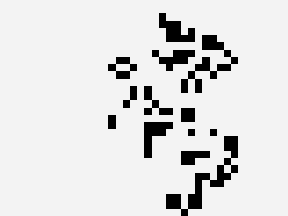
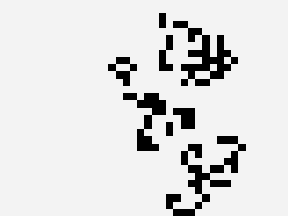
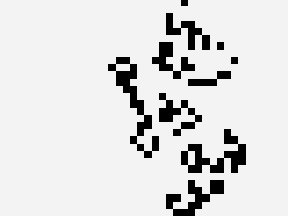
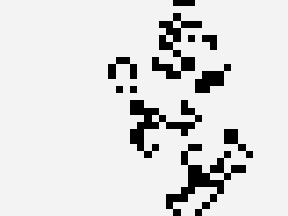
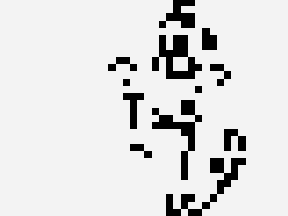
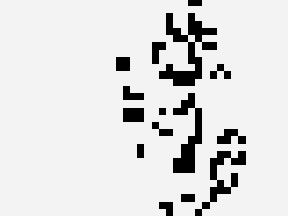
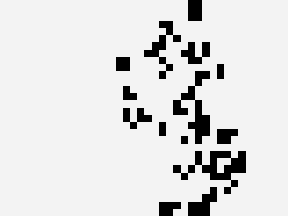
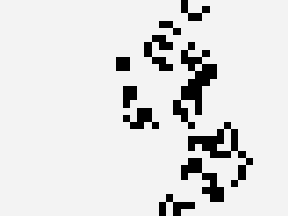
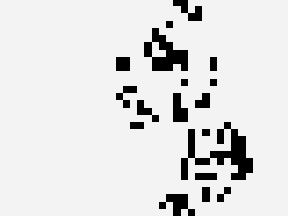
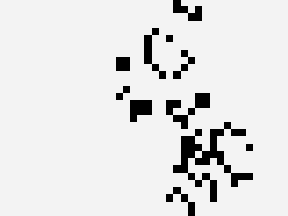
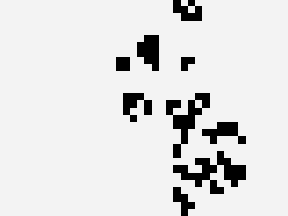
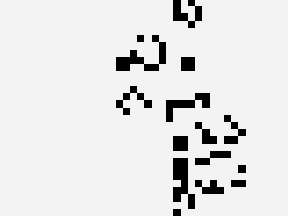
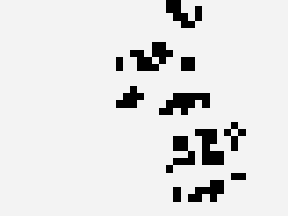
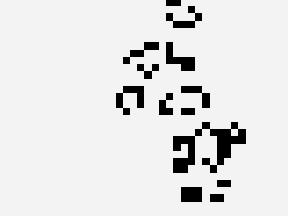
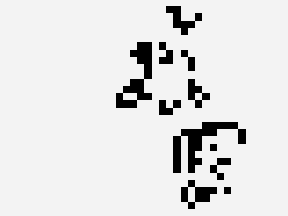

In [28]:
unbounded = [[0, 0, 0, 0, 0, 0, 1, 0],
             [0, 0, 0, 0, 1, 0, 1, 1],
             [0, 0, 0, 0, 1, 0, 1, 0],
             [0, 0, 0, 0, 1, 0, 0, 0],
             [0, 0, 1, 0, 0, 0, 0, 0],
             [1, 0, 1, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0, 0]]
X = np.zeros((30, 40))
X[15:23, 18:26] = unbounded
life_animation(X, dpi=10, frames=100, interval=200, mode='once')